## Hydrogen no Heat Flex Analysis 

Author: Katherine Shaw
Date: July 21, 2025

In [1]:
#Packages 
import pypsa
import matplotlib.pyplot as plt 
import cartopy 
import geopandas
import networkx
import linopy
import cartopy.crs as ccrs
import atlite 
import geopandas as gpd 
import xarray
import pandas as pd 
from datetime import datetime
import numpy as np
from pypsa.plot import add_legend_patches
import random
import plotly.graph_objects as go

## Overall view of colors matched to carriers 
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

#importing auxillary functions
import Auxillary_Functions as af

In [66]:
def bus_connections(network, bus_name): 
    if bus_name in network.buses.index.values:

        connected_generators = network.generators[network.generators.bus == bus_name]
        connected_loads = network.loads[network.loads.bus == bus_name]
        connected_storage_units = network.storage_units[network.storage_units.bus == bus_name]
        connected_links_in = network.links[network.links.bus1 == bus_name]
        connected_links_out = network.links[network.links.bus0 == bus_name]
        connected_lines = network.lines[(network.lines.bus0 == bus_name) | (network.lines.bus1 == bus_name)]
        connected_transformers = network.transformers[(network.transformers.bus0 == bus_name) | (network.transformers.bus1 == bus_name)]
        connected_stores = network.stores[network.stores.bus == bus_name]
        if any(connected_generators.index.values):
            print("The generators connected to this bus are:    " + str(connected_generators.index.values))
        if any(connected_loads.index.values):
            print("The loads connected to this bus are:     " + str(connected_loads.index.values))
        if any(connected_storage_units.index.values):
            print("The storage units connected to this bus are:   " + str(connected_storage_units.index.values))
        if any(connected_stores.index.values):
            print("The stores connected to this bus are:   " + str(connected_stores.index.values))
        if any(connected_links_in.index.values):
            print("The incoming links to this bus are from the bus:  " +  str(connected_links_in.bus0.values))
        if any(connected_links_in.index.values):
            print("The incoming links are:  " +  str(connected_links_in.index))
        if any(connected_links_out.index.values):
            print("The outgoing links from this bus are to the bus:  " +  str(connected_links_out.bus1.values))
        if any(connected_lines.index.values):
            print("The lines connected to this bus are connected to:   "  + str(connected_lines.bus1.values))
        if any(connected_transformers.index.values):
            print(connected_transformers.index.values)
        return None    
    else:      
        return str("This bus does not exist in the network")

In [258]:
def Sankey_biomass_hydrogen(network_choice):
    network = network_choice  # Use the 2050 network for this example
    #create the dataframe for the sankey 
    Sankey_data = pd.DataFrame(columns=['link name']) #, 'source', 'target',  'link_dispatch_from_source', 'link_arriving_at_target'])

    #identify the source buses, the links you want to evaluate start at these buses  
    # the same types of carriers should be the same color, and then the country level buses should be combined into one bus 
        #hydrogen buses 
    hydrogen_carriers = ['H2']
    hydrogen_buses = network.buses[network.buses.carrier.isin(hydrogen_carriers)].index
    #print(hydrogen_buses)
        #biomass buses 
    biomass_carrier = ['biogas', 'solid biomass','solid biomass for industry', 'unsustainable bioliquids', 'unsustainable biogas']
    biomass_buses = network.buses[network.buses.carrier.isin(biomass_carrier)].index
    #print(biomass_buses) 
    buses_options = biomass_buses.append(hydrogen_buses).copy()

    all_links = network.links[network.links.bus0.isin(buses_options)].index.copy()
    Sankey_data['link name'] = all_links.values
    #identifying the source buses 
    Sankey_data['source'] = Sankey_data['link name'].map((network.links.loc[all_links, 'bus0']))
    #identifying the target buses
    Sankey_data['target'] = Sankey_data['link name'].map((network.links.loc[all_links, 'bus1']))
    #recording the dispatch from the source bus
    dispatch_series = (network.links_t.p0[all_links].sum() * network.snapshot_weightings.objective[0]).copy()
    Sankey_data['link_dispatch_from_source'] = Sankey_data['link name'].map(dispatch_series) 
    #recording the energy arriving at the target bus 
    dispatch_series = (network.links_t.p1[all_links].sum() * network.snapshot_weightings.objective[0] * -1).copy()
    Sankey_data['link_arriving_at_target'] = Sankey_data['link name'].map(dispatch_series) 

    #isolating the links that have negative dispatch or arrival values
    negative_dispatch = Sankey_data[Sankey_data['link_dispatch_from_source'] < 0]
    negative_arrival = Sankey_data[Sankey_data['link_arriving_at_target'] < 0]
    negative_links = pd.concat([negative_dispatch, negative_arrival]).drop_duplicates().copy() #these are the links that are contributing power to the bus, not taking power from the bus, so they should be colored differently in the sankey diagram

    Sankey_data = Sankey_data.drop(negative_links.index, inplace = False)

    # Carrier info
    Sankey_data['carrier'] = Sankey_data['link name'].map(network.links.loc[all_links, 'carrier'])


    #aggregating sources, targets, and flows to carrier types (so I don't get one line for each country)
    to_remove = ['AL0 0', 'AT0 0', 'BA0 0', 'BE0 0', 'BG0 0',
    'CH0 0', 'CZ0 0', 'DE0 0', 'DK0 0', 'DK1 0',
    'EE0 0', 'ES0 0', 'ES6 0', 'FI1 0', 'FR0 0',
    'FR5 0', 'GB2 0', 'GB3 0', 'GR0 0', 'HR0 0',
    'HU0 0', 'IE3 0', 'IT0 0', 'IT4 0', 'LT0 0',
    'LU0 0', 'LV0 0', 'ME0 0', 'MK0 0', 'NL0 0',
    'NO1 0', 'PL0 0', 'PT0 0', 'RO0 0', 'RS0 0',
    'SE1 0', 'SI0 0', 'SK0 0', 'XK0 0']

    # Function to remove matching substrings
    def clean_value(val):
        for pattern in to_remove:
            val = val.replace(pattern, '')
        val =  val.strip()
        return val if val else 'electric network'

    Sankey_data['aggregate source'] = Sankey_data['source'].apply(clean_value)
    Sankey_data['aggregate targets'] = Sankey_data['target'].apply(clean_value)

    # Aggregate with carrier preserved (take first carrier in each group)
    agg_flows = Sankey_data.groupby(['aggregate source', 'aggregate targets']).agg({
        'link_dispatch_from_source': 'sum',
        'carrier': 'first'  # or another strategy if multiple carriers per link group
    }).reset_index()


    # Deduplicated node labels
    all_labels = pd.unique(agg_flows['aggregate source'].tolist() + agg_flows['aggregate targets'].tolist())
    label_to_id = {label: i for i, label in enumerate(all_labels)}


    #for construction of the sankey diagram 

    agg_flows['source_id'] = agg_flows['aggregate source'].map(label_to_id)
    agg_flows['target_id'] = agg_flows['aggregate targets'].map(label_to_id)
    agg_flows


    # Add custom hover text
    agg_flows['custom_text'] = (
        'Carrier: ' + agg_flows['carrier'] +
        '<br>From: ' + agg_flows['aggregate source'] +
        '<br>To: ' + agg_flows['aggregate targets'] +
        '<br>Flow: ' + agg_flows['link_dispatch_from_source MWh'].round(2).astype(str)
    )

    # Sankey Plot
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            label=list(all_labels),
            pad=15,
            thickness=20,
            line=dict(color='black', width=0.5)
        ),
        link=dict(
            source=agg_flows['source_id'],
            target=agg_flows['target_id'],
            value=agg_flows['link_dispatch_from_source'],
            customdata=agg_flows['custom_text'],
            hovertemplate='%{customdata}<extra></extra>'
        )
    )])

    fig.update_layout(title_text="Energy Flow Sankey Diagram with Carrier Info", font_size=12)
    fig.show()



# Loading ALL of the networks

### Scenario 2

In [8]:
#Minimum hydrogen usage == our new proxy for no hydrogen usage? 
Scenario2_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/min_scenario/networks/base_s_39___2020.nc')
Scenario2_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/min_scenario/networks/base_s_39___2030.nc')
Scenario2_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/min_scenario/networks/base_s_39___2040.nc')
Scenario2_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/min_scenario/networks/base_s_39___2050.nc')


INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


### Scenario 3.2 -- 10% above minimum

In [ ]:
### Scenario 3.2 -- 10% above minimum
Scenario3_2_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/10%/networks/base_s_39___2020.nc')
Scenario3_2_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/10%/networks/base_s_39___2020.nc')
Scenario3_2_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/10%/networks/base_s_39___2020.nc')
Scenario3_2_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/10%/networks/base_s_39___2020.nc')


INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


### Scenario 3.3 -- 30% above minimum

In [ ]:
### Scenario 3.3 -- 30% above minimum
Scenario3_3_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/30%/networks/base_s_39___2020.nc')
Scenario3_3_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/30%/networks/base_s_39___2020.nc')
Scenario3_3_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/30%/networks/base_s_39___2020.nc')
Scenario3_3_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/30%/networks/base_s_39___2020.nc')


INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


### Scenario 3.4 -- 10% above minimum with one period delay#

In [ ]:
### Scenario 3.4 -- 10% above minimum with one period delay#
Scenario3_4_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/results_10%_delay_one_period/networks/base_s_39___2020.nc')
Scenario3_4_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/results_10%_delay_one_period/networks/base_s_39___2030.nc')
Scenario3_4_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/results_10%_delay_one_period/networks/base_s_39___2040.nc')
Scenario3_4_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/results_10%_delay_one_period/networks/base_s_39___2050.nc')

### Scenario 3.5 -- 10% above minimum with two periods delay

In [ ]:
### Scenario 3.5 -- 10% above minimum with two periods delay
Scenario3_5_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/results_10%_delay_two_period/networks/base_s_39___2020.nc')
Scenario3_5_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/results_10%_delay_two_period/networks/base_s_39___2030.nc')
Scenario3_5_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/results_10%_delay_two_period/networks/base_s_39___2040.nc')
Scenario3_5_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/results_10%_delay_two_period/networks/base_s_39___2050.nc')

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


### Scenario 3.6 -- 10% above minimum with three periods delay

In [ ]:
### Scenario 3.6 -- 10% above minimum with three periods delay
Scenario3_6_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/results_10%_delay_three_periods/networks/base_s_39___2020.nc')
Scenario3_6_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/results_10%_delay_three_periods/networks/base_s_39___2030.nc')
Scenario3_6_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/results_10%_delay_three_periods/networks/base_s_39___2040.nc')
Scenario3_6_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/results_10%_delay_three_periods/networks/base_s_39___2050.nc')

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


### Scenario 3.7 -- 30% above minimum with one period delay#

In [ ]:
### Scenario 3.7 -- 30% above minimum with one period delay#
Scenario3_7_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/30%_with_one_delay/networks/base_s_39___2020.nc')
Scenario3_7_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/30%_with_one_delay/networks/base_s_39___2030.nc')
Scenario3_7_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/30%_with_one_delay/networks/base_s_39___2040.nc')
Scenario3_7_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/30%_with_one_delay/networks/base_s_39___2050.nc')

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


### Scenario 3.8 -- 30% above minimum with two periods delay

In [ ]:
### Scenario 3.8 -- 30% above minimum with two periods delay
Scenario3_8_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/30%_with_two_delay/networks/base_s_39___2020.nc')
Scenario3_8_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/30%_with_two_delay/networks/base_s_39___2030.nc')
Scenario3_8_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/30%_with_two_delay/networks/base_s_39___2040.nc')
Scenario3_8_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/30%_with_two_delay/networks/base_s_39___2050.nc')

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


### Scenario 3.9 -- 30% above minimum with three periods delay

In [15]:
Scenario3_8_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/30%_with_three_delay/networks/base_s_39___2020.nc')
Scenario3_8_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/30%_with_three_delay/networks/base_s_39___2030.nc')
Scenario3_8_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/30%_with_three_delay/networks/base_s_39___2040.nc')
Scenario3_8_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/30%_with_three_delay/networks/base_s_39___2050.nc')

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [324]:
#Scenario2 #Minimum hydrogen usage == our new proxy for no hydrogen usage? 
Scenario2_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/min_scenario/networks/base_s_39___2020.nc')
Scenario2_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/min_scenario/networks/base_s_39___2030.nc')
Scenario2_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/min_scenario/networks/base_s_39___2040.nc')
Scenario2_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/min_scenario/networks/base_s_39___2050.nc')


### Scenario 3.2 -- 10% above minimum
Scenario3_2_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/10%/networks/base_s_39___2020.nc')
Scenario3_2_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/10%/networks/base_s_39___2020.nc')
Scenario3_2_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/10%/networks/base_s_39___2020.nc')
Scenario3_2_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/10%/networks/base_s_39___2020.nc')

### Scenario 3.3 -- 30% above minimum
Scenario3_3_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/30%/networks/base_s_39___2020.nc')
Scenario3_3_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/30%/networks/base_s_39___2020.nc')
Scenario3_3_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/30%/networks/base_s_39___2020.nc')
Scenario3_3_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/30%/networks/base_s_39___2020.nc')

### Scenario 3.4 -- 10% above minimum with one period delay#
Scenario3_4_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/results_10%_delay_one_period/networks/base_s_39___2020.nc')
Scenario3_4_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/results_10%_delay_one_period/networks/base_s_39___2030.nc')
Scenario3_4_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/results_10%_delay_one_period/networks/base_s_39___2040.nc')
Scenario3_4_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/results_10%_delay_one_period/networks/base_s_39___2050.nc')

### Scenario 3.5 -- 10% above minimum with two periods delay
Scenario3_5_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/results_10%_delay_two_period/networks/base_s_39___2020.nc')
Scenario3_5_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/results_10%_delay_two_period/networks/base_s_39___2030.nc')
Scenario3_5_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/results_10%_delay_two_period/networks/base_s_39___2040.nc')
Scenario3_5_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/results_10%_delay_two_period/networks/base_s_39___2050.nc')

### Scenario 3.6 -- 10% above minimum with three periods delay
Scenario3_6_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/results_10%_delay_three_periods/networks/base_s_39___2020.nc')
Scenario3_6_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/results_10%_delay_three_periods/networks/base_s_39___2030.nc')
Scenario3_6_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/results_10%_delay_three_periods/networks/base_s_39___2040.nc')
Scenario3_6_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/results_10%_delay_three_periods/networks/base_s_39___2050.nc')

### Scenario 3.7 -- 30% above minimum with one period delay#
Scenario3_7_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/30%_with_one_delay/networks/base_s_39___2020.nc')
Scenario3_7_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/30%_with_one_delay/networks/base_s_39___2030.nc')
Scenario3_7_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/30%_with_one_delay/networks/base_s_39___2040.nc')
Scenario3_7_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/30%_with_one_delay/networks/base_s_39___2050.nc')

### Scenario 3.8 -- 30% above minimum with two periods delay
Scenario3_8_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/30%_with_two_delay/networks/base_s_39___2020.nc')
Scenario3_8_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/30%_with_two_delay/networks/base_s_39___2030.nc')
Scenario3_8_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/30%_with_two_delay/networks/base_s_39___2040.nc')
Scenario3_8_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/30%_with_two_delay/networks/base_s_39___2050.nc')

### Scenario 3.9 -- 30% above minimum with three periods delay
Scenario3_9_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/30%_with_three_delay/networks/base_s_39___2020.nc')
Scenario3_9_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/30%_with_three_delay/networks/base_s_39___2030.nc')
Scenario3_9_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/30%_with_three_delay/networks/base_s_39___2040.nc')
Scenario3_9_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/30%_with_three_delay/networks/base_s_39___2050.nc')




INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, 

In [262]:
# Scenario2 #Minimum hydrogen usage == our new proxy for no hydrogen usage? 
Scenario2_2020_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/minimum/networks/base_s_39___2020.nc')
Scenario2_2030_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/minimum/networks/base_s_39___2030.nc')
Scenario2_2040_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/minimum/networks/base_s_39___2040.nc')
Scenario2_2050_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/minimum/networks/base_s_39___2050.nc')

# Scenario 3.2 -- 10% above minimum
Scenario3_2_2020_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/10%/networks/base_s_39___2020.nc')
Scenario3_2_2030_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/10%/networks/base_s_39___2020.nc')
Scenario3_2_2040_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/10%/networks/base_s_39___2020.nc')
Scenario3_2_2050_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/10%/networks/base_s_39___2020.nc')

# Scenario 3.3 -- 30% above minimum
Scenario3_3_2020_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/30%/networks/base_s_39___2020.nc')
Scenario3_3_2030_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/30%/networks/base_s_39___2020.nc')
Scenario3_3_2040_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/30%/networks/base_s_39___2020.nc')
Scenario3_3_2050_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/30%/networks/base_s_39___2020.nc')

# Scenario 3.4 -- 10% above minimum with one period delay
Scenario3_4_2020_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/10%_one_period_delay/networks/base_s_39___2020.nc')
Scenario3_4_2030_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/10%_one_period_delay/networks/base_s_39___2030.nc')
Scenario3_4_2040_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/10%_one_period_delay/networks/base_s_39___2040.nc')
Scenario3_4_2050_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/10%_one_period_delay/networks/base_s_39___2050.nc')

# Scenario 3.5 -- 10% above minimum with two periods delay
Scenario3_5_2020_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/10%_two_period_delay/networks/base_s_39___2020.nc')
Scenario3_5_2030_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/10%_two_period_delay/networks/base_s_39___2030.nc')
Scenario3_5_2040_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/10%_two_period_delay/networks/base_s_39___2040.nc')
Scenario3_5_2050_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/10%_two_period_delay/networks/base_s_39___2050.nc')

# Scenario 3.6 -- 10% above minimum with three periods delay
Scenario3_6_2020_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/10%_three_period_delay/networks/base_s_39___2020.nc')
Scenario3_6_2030_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/10%_three_period_delay/networks/base_s_39___2030.nc')
Scenario3_6_2040_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/10%_three_period_delay/networks/base_s_39___2040.nc')
Scenario3_6_2050_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/10%_three_period_delay/networks/base_s_39___2050.nc')

# Scenario 3.7 -- 30% above minimum with one period delay
Scenario3_7_2020_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/30%_one_period_delay/networks/base_s_39___2020.nc')
Scenario3_7_2030_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/30%_one_period_delay/networks/base_s_39___2030.nc')
Scenario3_7_2040_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/30%_one_period_delay/networks/base_s_39___2040.nc')
Scenario3_7_2050_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/30%_one_period_delay/networks/base_s_39___2050.nc')

# Scenario 3.8 -- 30% above minimum with two periods delay
Scenario3_8_2020_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/30%_two_period_delay/networks/base_s_39___2020.nc')
Scenario3_8_2030_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/30%_two_period_delay/networks/base_s_39___2030.nc')
Scenario3_8_2040_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/30%_two_period_delay/networks/base_s_39___2040.nc')
Scenario3_8_2050_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/30%_two_period_delay/networks/base_s_39___2050.nc')

# Scenario 3.9 -- 30% above minimum with three periods delay
Scenario3_9_2020_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/30%_three_period_delay/networks/base_s_39___2020.nc')
Scenario3_9_2030_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/30%_three_period_delay/networks/base_s_39___2030.nc')
Scenario3_9_2040_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/30%_three_period_delay/networks/base_s_39___2040.nc')
Scenario3_9_2050_30pct_BEV_availability = pypsa.Network('/Users/katherine.shaw/Desktop/Late_July_Hydrogen_tests_1/withlessBEVavailability/30%_three_period_delay/networks/base_s_39___2050.nc')


INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, 

In [325]:
#lists of all scenarios in a list with all their networks in chronological order
Scenarios2 = [Scenario2_2020, Scenario2_2030, Scenario2_2040, Scenario2_2050]
Scenarios3_2 = [Scenario3_2_2020, Scenario3_2_2030, Scenario3_2_2040, Scenario3_2_2050]
Scenarios3_3 = [Scenario3_3_2020, Scenario3_3_2030, Scenario3_3_2040, Scenario3_3_2050]
Scenarios3_4 = [Scenario3_4_2020, Scenario3_4_2030, Scenario3_4_2040, Scenario3_4_2050]
Scenarios3_5 = [Scenario3_5_2020, Scenario3_5_2030, Scenario3_5_2040, Scenario3_5_2050]
Scenarios3_6 = [Scenario3_6_2020, Scenario3_6_2030, Scenario3_6_2040, Scenario3_6_2050]
Scenarios3_7 = [Scenario3_7_2020, Scenario3_7_2030, Scenario3_7_2040, Scenario3_7_2050]
Scenarios3_8 = [Scenario3_8_2020, Scenario3_8_2030, Scenario3_8_2040, Scenario3_8_2050]
Scenarios3_9 = [Scenario3_9_2020, Scenario3_9_2030, Scenario3_9_2040, Scenario3_9_2050]

In [332]:
#lists of all secnarios for each year
Scenario2020 = [Scenario2_2020, Scenario3_2_2020, Scenario3_3_2020, Scenario3_4_2020,  Scenario3_5_2020,Scenario3_6_2020, Scenario3_7_2020, Scenario3_8_2020, Scenario3_9_2020]
Scenario2030 = [Scenario2_2030, Scenario3_2_2030, Scenario3_3_2030, Scenario3_4_2030, Scenario3_5_2030, Scenario3_6_2030, Scenario3_7_2030, Scenario3_8_2030, Scenario3_9_2030]
Scenario2040 = [Scenario2_2040, Scenario3_2_2040, Scenario3_3_2040, Scenario3_4_2040, Scenario3_5_2040, Scenario3_6_2040, Scenario3_7_2040, Scenario3_8_2040, Scenario3_9_2040]
Scenario2050 = [Scenario2_2050, Scenario3_2_2050, Scenario3_3_2050, Scenario3_4_2050, Scenario3_5_2050, Scenario3_6_2050, Scenario3_7_2050, Scenario3_8_2050, Scenario3_9_2050]


In [327]:
# Lists of all scenarios in a list with all their networks in chronological order -- with BEV adjustments 
Scenarios2_30pct_BEV_availability = [Scenario2_2020_30pct_BEV_availability, Scenario2_2030_30pct_BEV_availability, Scenario2_2040_30pct_BEV_availability, Scenario2_2050_30pct_BEV_availability]
Scenarios3_2_30pct_BEV_availability = [Scenario3_2_2020_30pct_BEV_availability, Scenario3_2_2030_30pct_BEV_availability, Scenario3_2_2040_30pct_BEV_availability, Scenario3_2_2050_30pct_BEV_availability]
Scenarios3_3_30pct_BEV_availability = [Scenario3_3_2020_30pct_BEV_availability, Scenario3_3_2030_30pct_BEV_availability, Scenario3_3_2040_30pct_BEV_availability, Scenario3_3_2050_30pct_BEV_availability]
Scenarios3_4_30pct_BEV_availability = [Scenario3_4_2020_30pct_BEV_availability, Scenario3_4_2030_30pct_BEV_availability, Scenario3_4_2040_30pct_BEV_availability, Scenario3_4_2050_30pct_BEV_availability]
Scenarios3_5_30pct_BEV_availability = [Scenario3_5_2020_30pct_BEV_availability, Scenario3_5_2030_30pct_BEV_availability, Scenario3_5_2040_30pct_BEV_availability, Scenario3_5_2050_30pct_BEV_availability]
Scenarios3_6_30pct_BEV_availability = [Scenario3_6_2020_30pct_BEV_availability, Scenario3_6_2030_30pct_BEV_availability, Scenario3_6_2040_30pct_BEV_availability, Scenario3_6_2050_30pct_BEV_availability]
Scenarios3_7_30pct_BEV_availability = [Scenario3_7_2020_30pct_BEV_availability, Scenario3_7_2030_30pct_BEV_availability, Scenario3_7_2040_30pct_BEV_availability, Scenario3_7_2050_30pct_BEV_availability]
Scenarios3_8_30pct_BEV_availability = [Scenario3_8_2020_30pct_BEV_availability, Scenario3_8_2030_30pct_BEV_availability, Scenario3_8_2040_30pct_BEV_availability, Scenario3_8_2050_30pct_BEV_availability]
Scenarios3_9_30pct_BEV_availability = [Scenario3_9_2020_30pct_BEV_availability, Scenario3_9_2030_30pct_BEV_availability, Scenario3_9_2040_30pct_BEV_availability, Scenario3_9_2050_30pct_BEV_availability]



In [328]:
# Lists of all scenarios for each year
Scenario2020_30pct_BEV_availability = [
    Scenario2_2020_30pct_BEV_availability,
    Scenario3_2_2020_30pct_BEV_availability,
    Scenario3_3_2020_30pct_BEV_availability,
    Scenario3_4_2020_30pct_BEV_availability,
    Scenario3_5_2020_30pct_BEV_availability,
    Scenario3_6_2020_30pct_BEV_availability,
    Scenario3_7_2020_30pct_BEV_availability,
    Scenario3_8_2020_30pct_BEV_availability,
    Scenario3_9_2020_30pct_BEV_availability
]

Scenario2030_30pct_BEV_availability = [
    Scenario2_2030_30pct_BEV_availability,
    Scenario3_2_2030_30pct_BEV_availability,
    Scenario3_3_2030_30pct_BEV_availability,
    Scenario3_4_2030_30pct_BEV_availability,
    Scenario3_5_2030_30pct_BEV_availability,
    Scenario3_6_2030_30pct_BEV_availability,
    Scenario3_7_2030_30pct_BEV_availability,
    Scenario3_8_2030_30pct_BEV_availability,
    Scenario3_9_2030_30pct_BEV_availability

]

Scenario2040_30pct_BEV_availability = [
    Scenario2_2040_30pct_BEV_availability,
    Scenario3_2_2040_30pct_BEV_availability,
    Scenario3_3_2040_30pct_BEV_availability,
    Scenario3_4_2040_30pct_BEV_availability,
    Scenario3_5_2040_30pct_BEV_availability,
    Scenario3_6_2040_30pct_BEV_availability,
    Scenario3_7_2040_30pct_BEV_availability,
    Scenario3_8_2040_30pct_BEV_availability,
    Scenario3_8_2040_30pct_BEV_availability
]

Scenario2050_30pct_BEV_availability = [
    Scenario2_2050_30pct_BEV_availability,
    Scenario3_2_2050_30pct_BEV_availability,
    Scenario3_3_2050_30pct_BEV_availability,
    Scenario3_4_2050_30pct_BEV_availability,
    Scenario3_5_2050_30pct_BEV_availability,
    Scenario3_6_2050_30pct_BEV_availability,
    Scenario3_7_2050_30pct_BEV_availability,
    Scenario3_8_2050_30pct_BEV_availability,
    Scenario3_8_2050_30pct_BEV_availability
]


# Analysis 

The ones that should be the most different are the ones with no hydrogen and all the hydrogen, aka Scenarios 2 and Scenarios 3_6, Scenarios3_8 


In [26]:
#Analysis of General statistics

curtailment_2020 = []
curtatilment_2030 = []
curtailment_2040 = []
curtailment_2050 = []

for net_type in [Scenarios2,Scenarios3_6, Scenarios3_6]: #for each network
    for net in range(4): #iterate through the networks 
        network = net_type[net]
        curtailment_value = network.statistics().Curtailment 
        if net == 0: 
            curtailment_2020.append(curtailment_value)
        elif net == 1:
            curtatilment_2030.append(curtailment_value)
        elif net == 2:
            curtailment_2040.append(curtailment_value)
        elif net == 3:
            curtailment_2050.append(curtailment_value)
        else:
            print('network not valid')
            

In [ ]:
df_curtailment_2020 = pd.DataFrame(curtailment_2020)
df_curtailment_2020.index = ['Scenario2', 'Scenario3_6', 'Scenario3_8']
df_curtailment_renewables = df_curtailment_2020['Generator'].copy()
 #'Offshore Wind (AC)', 'Offshore Wind (DC)', 'Offshore Wind (Floating)','Onshore Wind', 'Run of River', 'Solar','solar rooftop', 'solar-hsat',
renewable_generators = ['Offshore Wind (AC)', 'Offshore Wind (DC)', 'Offshore Wind (Floating)','Onshore Wind', 'Run of River', 'Solar','solar rooftop', 'solar-hsat']
df_curtailment_renewables[renewable_generators].sum(axis=1)
#this means nothing if the renewable mix is different 

Scenario2      8.600989e+06
Scenario3_6    8.601092e+06
Scenario3_8    8.601092e+06
dtype: float64

In [40]:
df_curtailment_2050 = pd.DataFrame(curtailment_2050)
df_curtailment_2050.index = ['Scenario2', 'Scenario3_6', 'Scenario3_8']
df_curtailment_renewables = df_curtailment_2050['Generator'].copy()
 #'Offshore Wind (AC)', 'Offshore Wind (DC)', 'Offshore Wind (Floating)','Onshore Wind', 'Run of River', 'Solar','solar rooftop', 'solar-hsat',
renewable_generators = ['Offshore Wind (AC)', 'Offshore Wind (DC)', 'Offshore Wind (Floating)','Onshore Wind', 'Run of River', 'Solar','solar rooftop', 'solar-hsat']
df_curtailment_renewables[renewable_generators].sum(axis=1)
#this means nothing if the renewable mix is different 

Scenario2      2.881028e+08
Scenario3_6    2.754065e+08
Scenario3_8    2.754065e+08
dtype: float64

In [329]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#maybe just get rid of oil primary because that goes to fuels, 
#need thermal because it will become electrified 
#the avail-used #this doesn't work for non-renewables because obviously curtailment for them is not a technological question for time seriess, but also need to address that it's in MW and statistics curtailment is in MWH


#This needs to be for all scenarios, will group by year 
index_names_2020 = ['Scenario2_2020', 'Scenario3_2_2020', 'Scenario3_3_2020', 'Scenario3_4_2020', 'Scenario3_5_2020','Scenario3_6_2020', 'Scenario3_7_2020', 'Scenario3_8_2020', 'Scenario3_9_2020']
dataframe_2020_curtailment = pd.DataFrame()
dataframe_2020_curtailment.index = index_names_2020
dataframe_2020_curtailment

#initial setup of all the columns is 0.0 (because it helped me map what I needed to view)
dataframe_2020_curtailment['total_energy_generated [Mwh]'] = np.zeros(len(index_names_2020))
for index_value, net in enumerate(Scenario2020):
    generator_supply = net.statistics()['Supply'].loc['Generator']
    generator_supply = generator_supply.drop('oil primary')
    generator_supply = generator_supply.sum().sum()
    dataframe_2020_curtailment['total_energy_generated [Mwh]'][index_value] = generator_supply
#get only renewable values of supply
dataframe_2020_curtailment['renewable_energy_generated [MWh]'] = np.zeros(len(index_names_2020))
for index_value, net in enumerate(Scenario2020):
    generator_supply = net.statistics()['Supply'].loc['Generator']
    generator_supply = generator_supply.drop('oil primary')
    generator_supply = generator_supply.loc[renewables_str]
    generator_supply = generator_supply.sum().sum()
    dataframe_2020_curtailment['renewable_energy_generated [MWh]'][index_value] = generator_supply

#optimal capacity
dataframe_2020_curtailment['Optimal Capacity of renewables [MW]'] = np.zeros(len(index_names_2020))
for index_value, net in enumerate(Scenario2020):
    generator_supply = net.statistics()['Optimal Capacity'].loc['Generator']
    generator_supply = generator_supply.drop('oil primary')
    generator_supply = generator_supply.loc[renewables_str]
    generator_supply = generator_supply.sum().sum()
    dataframe_2020_curtailment['Optimal Capacity of renewables [MW]'][index_value] = generator_supply

#amount of energy curtailed 
dataframe_2020_curtailment['amount of energy curtailed [MWh]'] = np.zeros(len(index_names_2020))
for index_value, net in enumerate(Scenario2020):
    avail = (
        net.generators_t.p_max_pu.multiply(network.generators.p_nom_opt)
        .sum()
        .groupby(network.generators.carrier)
        .sum()
    )
    used = net.generators_t.p.sum().groupby(net.generators.carrier).sum()
    curtailment_values = ((avail - used) * net.snapshot_weightings.objective[0])[(avail - used) * net.snapshot_weightings.objective[0] > 0]
    curtailment_values = curtailment_values.sum()
    dataframe_2020_curtailment['amount of energy curtailed [MWh]'][index_value] = curtailment_values

#ratio of curtailed power to total power 
dataframe_2020_curtailment['ratio of curtailed power to total power [-]'] = np.zeros(len(index_names_2020))
for index_value, net in enumerate(Scenario2020):
    dataframe_2020_curtailment['ratio of curtailed power to total power [-]'] = dataframe_2020_curtailment['amount of energy curtailed [MWh]'] / dataframe_2020_curtailment['renewable_energy_generated [MWh]']

#percentage of hours were curtailment took place 
dataframe_2020_curtailment['percentage of hours where curtailment took place'] = np.zeros(len(index_names_2020))





dataframe_2020_curtailment

,total_energy_generated [Mwh],renewable_energy_generated [MWh],Optimal Capacity of renewables [MW],amount of energy curtailed [MWh],ratio of curtailed power to total power [-],percentage of hours where curtailment took place
Scenario2_2020,9.498569e+09,1.283422e+09,677585.82202,1.131271e+05,0.000088,0.0
Scenario3_2_2020,9.496978e+09,1.280410e+09,676061.03324,3.720016e+06,0.002905,0.0
Scenario3_3_2020,9.497028e+09,1.280356e+09,676033.97935,3.891895e+06,0.003040,0.0
Scenario3_4_2020,9.499739e+09,1.284433e+09,677894.25933,5.521011e+05,0.000430,0.0
Scenario3_5_2020,9.496970e+09,1.280410e+09,676061.26751,3.245098e+06,0.002534,0.0
Scenario3_6_2020,9.498528e+09,1.283179e+09,677462.67673,4.722132e+05,0.000368,0.0
Scenario3_7_2020,9.498561e+09,1.283398e+09,677574.42030,1.331049e+05,0.000104,0.0
Scenario3_8_2020,9.498531e+09,1.283187e+09,677467.20628,1.053710e+06,0.000821,0.0
Scenario3_9_2020,9.498512e+09,1.283180e+09,677463.03711,3.648479e+05,0.000284,0.0


In [334]:
#for 2030
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#maybe just get rid of oil primary because that goes to fuels, 
#need thermal because it will become electrified 
#the avail-used #this doesn't work for non-renewables because obviously curtailment for them is not a technological question for time seriess, but also need to address that it's in MW and statistics curtailment is in MWH


#This needs to be for all scenarios, will group by year 
index_names_2030 = ['Scenario2_2030', 'Scenario3_2_2030', 'Scenario3_3_2030', 'Scenario3_4_2030', 'Scenario3_5_2030','Scenario3_6_2030', 'Scenario3_7_2030', 'Scenario3_8_2030', 'Scenario3_9_2030']
dataframe_2030_curtailment = pd.DataFrame()
dataframe_2030_curtailment.index = index_names_2030
dataframe_2030_curtailment

#initial setup of all the columns is 0.0 (because it helped me map what I needed to view)
dataframe_2030_curtailment['total_energy_generated [Mwh]'] = np.zeros(len(index_names_2030))
for index_value, net in enumerate(Scenario2030):
    generator_supply = net.statistics()['Supply'].loc['Generator']
    generator_supply = generator_supply.drop('oil primary')
    generator_supply = generator_supply.sum().sum()
    dataframe_2030_curtailment['total_energy_generated [Mwh]'][index_value] = generator_supply
#get only renewable values of supply
dataframe_2030_curtailment['renewable_energy_generated [MWh]'] = np.zeros(len(index_names_2030))
for index_value, net in enumerate(Scenario2030):
    generator_supply = net.statistics()['Supply'].loc['Generator']
    generator_supply = generator_supply.drop('oil primary')
    generator_supply = generator_supply.loc[renewables_str]
    generator_supply = generator_supply.sum().sum()
    dataframe_2030_curtailment['renewable_energy_generated [MWh]'][index_value] = generator_supply

#optimal capacity
dataframe_2030_curtailment['Optimal Capacity of renewables [MW]'] = np.zeros(len(index_names_2030))
for index_value, net in enumerate(Scenario2030):
    generator_supply = net.statistics()['Optimal Capacity'].loc['Generator']
    generator_supply = generator_supply.drop('oil primary')
    generator_supply = generator_supply.loc[renewables_str]
    generator_supply = generator_supply.sum().sum()
    dataframe_2030_curtailment['Optimal Capacity of renewables [MW]'][index_value] = generator_supply

#amount of energy curtailed 
dataframe_2030_curtailment['amount of energy curtailed [MWh]'] = np.zeros(len(index_names_2030))
for index_value, net in enumerate(Scenario2030):
    avail = (
        net.generators_t.p_max_pu.multiply(network.generators.p_nom_opt)
        .sum()
        .groupby(network.generators.carrier)
        .sum()
    )
    used = net.generators_t.p.sum().groupby(net.generators.carrier).sum()
    curtailment_values = ((avail - used) * net.snapshot_weightings.objective[0])[(avail - used) * net.snapshot_weightings.objective[0] > 0]
    curtailment_values = curtailment_values.sum()
    dataframe_2030_curtailment['amount of energy curtailed [MWh]'][index_value] = curtailment_values

#ratio of curtailed power to total power 
dataframe_2030_curtailment['ratio of curtailed power to total power [-]'] = np.zeros(len(index_names_2030))
for index_value, net in enumerate(Scenario2030):
    dataframe_2030_curtailment['ratio of curtailed power to total power [-]'] = dataframe_2030_curtailment['amount of energy curtailed [MWh]'] / dataframe_2030_curtailment['renewable_energy_generated [MWh]']

#percentage of hours were curtailment took place 
dataframe_2030_curtailment['percentage of hours where curtailment took place'] = np.zeros(len(index_names_2030))





dataframe_2030_curtailment


,total_energy_generated [Mwh],renewable_energy_generated [MWh],Optimal Capacity of renewables [MW],amount of energy curtailed [MWh],ratio of curtailed power to total power [-],percentage of hours where curtailment took place
Scenario2_2030,8.129180e+09,2.789474e+09,1.527916e+06,1.018307e+07,0.003651,0.0
Scenario3_2_2030,9.496978e+09,1.280410e+09,6.760610e+05,3.720016e+06,0.002905,0.0
Scenario3_3_2030,9.497028e+09,1.280356e+09,6.760340e+05,3.891895e+06,0.003040,0.0
Scenario3_4_2030,8.124893e+09,2.782833e+09,1.523301e+06,2.022673e+07,0.007268,0.0
Scenario3_5_2030,8.128998e+09,2.789160e+09,1.527650e+06,1.058087e+07,0.003794,0.0
Scenario3_6_2030,8.129064e+09,2.789257e+09,1.527829e+06,1.042105e+07,0.003736,0.0
Scenario3_7_2030,8.094066e+09,2.744890e+09,1.501653e+06,5.924525e+07,0.021584,0.0
Scenario3_8_2030,8.129154e+09,2.789483e+09,1.527958e+06,1.017383e+07,0.003647,0.0
Scenario3_9_2030,8.129137e+09,2.789463e+09,1.527952e+06,1.019468e+07,0.003655,0.0


In [335]:
#for 2040
#for 2040
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#maybe just get rid of oil primary because that goes to fuels, 
#need thermal because it will become electrified 
#the avail-used #this doesn't work for non-renewables because obviously curtailment for them is not a technological question for time seriess, but also need to address that it's in MW and statistics curtailment is in MWH


#This needs to be for all scenarios, will group by year 
index_names_2040 = ['Scenario2_2040', 'Scenario3_2_2040', 'Scenario3_3_2040', 'Scenario3_4_2040', 'Scenario3_5_2040','Scenario3_6_2040', 'Scenario3_7_2040', 'Scenario3_8_2040', 'Scenario3_9_2040']
dataframe_2040_curtailment = pd.DataFrame()
dataframe_2040_curtailment.index = index_names_2040
dataframe_2040_curtailment

#initial setup of all the columns is 0.0 (because it helped me map what I needed to view)
dataframe_2040_curtailment['total_energy_generated [Mwh]'] = np.zeros(len(index_names_2040))
for index_value, net in enumerate(Scenario2040):
    generator_supply = net.statistics()['Supply'].loc['Generator']
    generator_supply = generator_supply.drop('oil primary')
    generator_supply = generator_supply.sum().sum()
    dataframe_2040_curtailment['total_energy_generated [Mwh]'][index_value] = generator_supply
#get only renewable values of supply
dataframe_2040_curtailment['renewable_energy_generated [MWh]'] = np.zeros(len(index_names_2040))
for index_value, net in enumerate(Scenario2040):
    generator_supply = net.statistics()['Supply'].loc['Generator']
    generator_supply = generator_supply.drop('oil primary')
    generator_supply = generator_supply.loc[renewables_str]
    generator_supply = generator_supply.sum().sum()
    dataframe_2040_curtailment['renewable_energy_generated [MWh]'][index_value] = generator_supply

#optimal capacity
dataframe_2040_curtailment['Optimal Capacity of renewables [MW]'] = np.zeros(len(index_names_2040))
for index_value, net in enumerate(Scenario2040):
    generator_supply = net.statistics()['Optimal Capacity'].loc['Generator']
    generator_supply = generator_supply.drop('oil primary')
    generator_supply = generator_supply.loc[renewables_str]
    generator_supply = generator_supply.sum().sum()
    dataframe_2040_curtailment['Optimal Capacity of renewables [MW]'][index_value] = generator_supply

#amount of energy curtailed 
dataframe_2040_curtailment['amount of energy curtailed [MWh]'] = np.zeros(len(index_names_2040))
for index_value, net in enumerate(Scenario2040):
    avail = (
        net.generators_t.p_max_pu.multiply(network.generators.p_nom_opt)
        .sum()
        .groupby(network.generators.carrier)
        .sum()
    )
    used = net.generators_t.p.sum().groupby(net.generators.carrier).sum()
    curtailment_values = ((avail - used) * net.snapshot_weightings.objective[0])[(avail - used) * net.snapshot_weightings.objective[0] > 0]
    curtailment_values = curtailment_values.sum()
    dataframe_2040_curtailment['amount of energy curtailed [MWh]'][index_value] = curtailment_values

#ratio of curtailed power to total power 
dataframe_2040_curtailment['ratio of curtailed power to total power [-]'] = np.zeros(len(index_names_2040))
for index_value, net in enumerate(Scenario2040):
    dataframe_2040_curtailment['ratio of curtailed power to total power [-]'] = dataframe_2040_curtailment['amount of energy curtailed [MWh]'] / dataframe_2040_curtailment['renewable_energy_generated [MWh]']

#percentage of hours were curtailment took place 
dataframe_2040_curtailment['percentage of hours where curtailment took place'] = np.zeros(len(index_names_2040))





dataframe_2040_curtailment


,total_energy_generated [Mwh],renewable_energy_generated [MWh],Optimal Capacity of renewables [MW],amount of energy curtailed [MWh],ratio of curtailed power to total power [-],percentage of hours where curtailment took place
Scenario2_2040,1.061964e+10,8.624143e+09,4.463894e+06,2.292080e+08,0.026577,0.0
Scenario3_2_2040,9.496978e+09,1.280410e+09,6.760610e+05,3.720016e+06,0.002905,0.0
Scenario3_3_2040,9.497028e+09,1.280356e+09,6.760340e+05,3.891895e+06,0.003040,0.0
Scenario3_4_2040,1.088346e+10,8.648728e+09,4.517968e+06,8.589137e+07,0.009931,0.0
Scenario3_5_2040,1.069173e+10,8.462709e+09,4.531413e+06,1.352738e+08,0.015985,0.0
Scenario3_6_2040,1.061656e+10,8.627374e+09,4.418720e+06,2.194759e+08,0.025439,0.0
Scenario3_7_2040,1.089642e+10,8.406012e+09,4.644234e+06,1.160402e+08,0.013804,0.0
Scenario3_8_2040,1.089982e+10,8.408869e+09,4.639342e+06,7.400419e+07,0.008801,0.0
Scenario3_9_2040,1.061628e+10,8.627119e+09,4.418594e+06,2.193439e+08,0.025425,0.0


In [336]:
#for 2050
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#maybe just get rid of oil primary because that goes to fuels, 
#need thermal because it will become electrified 
#the avail-used #this doesn't work for non-renewables because obviously curtailment for them is not a technological question for time seriess, but also need to address that it's in MW and statistics curtailment is in MWH


#This needs to be for all scenarios, will group by year 
index_names_2050 = ['Scenario2_2050', 'Scenario3_2_2050', 'Scenario3_3_2050', 'Scenario3_4_2050', 'Scenario3_5_2050','Scenario3_6_2050', 'Scenario3_7_2050', 'Scenario3_8_2050', 'Scenario3_9_2050']
dataframe_2050_curtailment = pd.DataFrame()
dataframe_2050_curtailment.index = index_names_2050
dataframe_2050_curtailment

#initial setup of all the columns is 0.0 (because it helped me map what I needed to view)
dataframe_2050_curtailment['total_energy_generated [Mwh]'] = np.zeros(len(index_names_2050))
for index_value, net in enumerate(Scenario2050):
    generator_supply = net.statistics()['Supply'].loc['Generator']
    generator_supply = generator_supply.drop('oil primary')
    generator_supply = generator_supply.sum().sum()
    dataframe_2050_curtailment['total_energy_generated [Mwh]'][index_value] = generator_supply
#get only renewable values of supply
dataframe_2050_curtailment['renewable_energy_generated [MWh]'] = np.zeros(len(index_names_2050))
for index_value, net in enumerate(Scenario2050):
    generator_supply = net.statistics()['Supply'].loc['Generator']
    generator_supply = generator_supply.drop('oil primary')
    generator_supply = generator_supply.loc[renewables_str]
    generator_supply = generator_supply.sum().sum()
    dataframe_2050_curtailment['renewable_energy_generated [MWh]'][index_value] = generator_supply

#optimal capacity
dataframe_2050_curtailment['Optimal Capacity of renewables [MW]'] = np.zeros(len(index_names_2050))
for index_value, net in enumerate(Scenario2050):
    generator_supply = net.statistics()['Optimal Capacity'].loc['Generator']
    generator_supply = generator_supply.drop('oil primary')
    generator_supply = generator_supply.loc[renewables_str]
    generator_supply = generator_supply.sum().sum()
    dataframe_2050_curtailment['Optimal Capacity of renewables [MW]'][index_value] = generator_supply

#amount of energy curtailed 
dataframe_2050_curtailment['amount of energy curtailed [MWh]'] = np.zeros(len(index_names_2050))
for index_value, net in enumerate(Scenario2050):
    avail = (
        net.generators_t.p_max_pu.multiply(network.generators.p_nom_opt)
        .sum()
        .groupby(network.generators.carrier)
        .sum()
    )
    used = net.generators_t.p.sum().groupby(net.generators.carrier).sum()
    curtailment_values = ((avail - used) * net.snapshot_weightings.objective[0])[(avail - used) * net.snapshot_weightings.objective[0] > 0]
    curtailment_values = curtailment_values.sum()
    dataframe_2050_curtailment['amount of energy curtailed [MWh]'][index_value] = curtailment_values

#ratio of curtailed power to total power 
dataframe_2050_curtailment['ratio of curtailed power to total power [-]'] = np.zeros(len(index_names_2050))
for index_value, net in enumerate(Scenario2050):
    dataframe_2050_curtailment['ratio of curtailed power to total power [-]'] = dataframe_2050_curtailment['amount of energy curtailed [MWh]'] / dataframe_2050_curtailment['renewable_energy_generated [MWh]']

#percentage of hours were curtailment took place 
dataframe_2050_curtailment['percentage of hours where curtailment took place'] = np.zeros(len(index_names_2050))





dataframe_2050_curtailment


,total_energy_generated [Mwh],renewable_energy_generated [MWh],Optimal Capacity of renewables [MW],amount of energy curtailed [MWh],ratio of curtailed power to total power [-],percentage of hours where curtailment took place
Scenario2_2050,1.013814e+10,8.515480e+09,4.216093e+06,1.437792e+08,0.016884,0.0
Scenario3_2_2050,9.496978e+09,1.280410e+09,6.760610e+05,3.720016e+06,0.002905,0.0
Scenario3_3_2050,9.497028e+09,1.280356e+09,6.760340e+05,3.891895e+06,0.003040,0.0
Scenario3_4_2050,1.017052e+10,8.265400e+09,4.270164e+06,5.417439e+07,0.006554,0.0
Scenario3_5_2050,1.011690e+10,8.223460e+09,4.283614e+06,7.102866e+07,0.008637,0.0
Scenario3_6_2050,1.013601e+10,8.517336e+09,4.170920e+06,1.353659e+08,0.015893,0.0
Scenario3_7_2050,1.012335e+10,8.023447e+09,4.397434e+06,8.143030e+07,0.010149,0.0
Scenario3_8_2050,1.012233e+10,8.026733e+09,4.392542e+06,3.824186e+07,0.004764,0.0
Scenario3_9_2050,1.013564e+10,8.516975e+09,4.170795e+06,1.335218e+08,0.015677,0.0


#does it displace thermal energy or oil or anything else? 

Less curtailment the more hydrogen you have, need varying levels of BEV integration as input probably

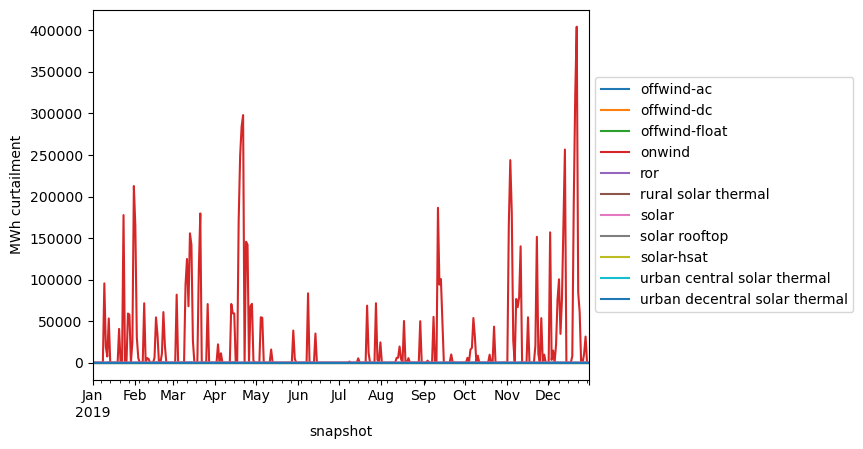

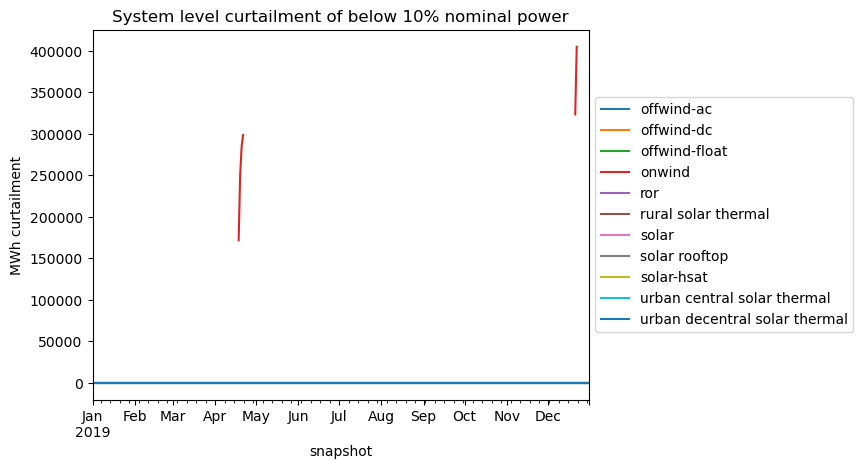

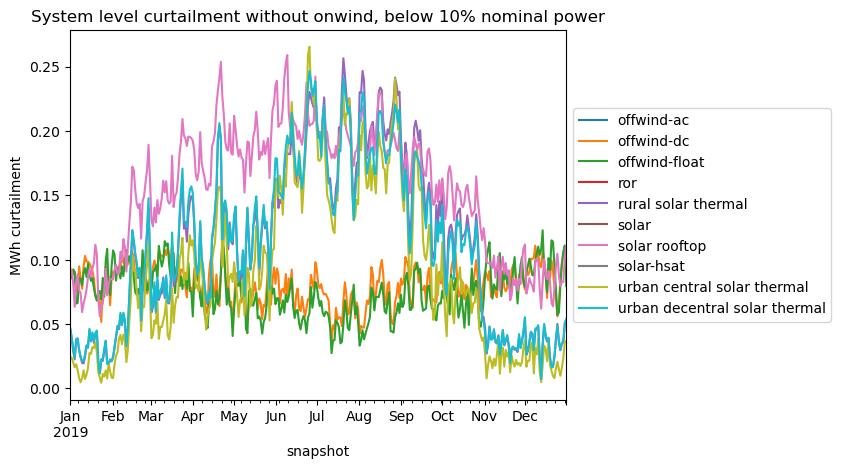

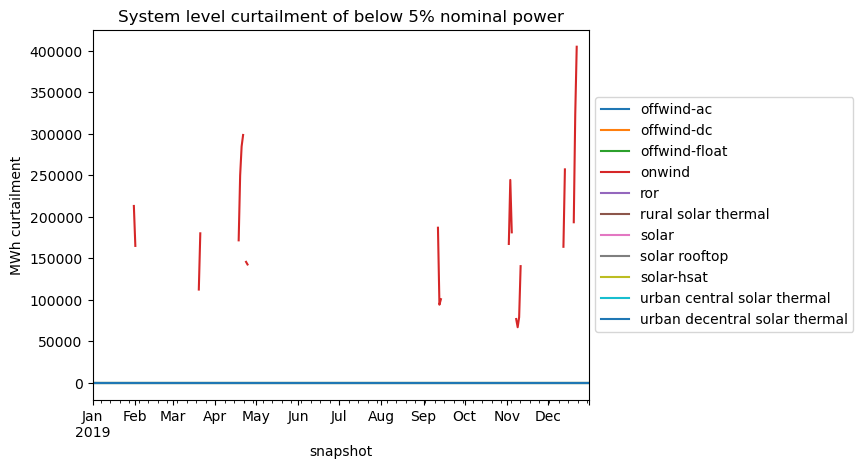

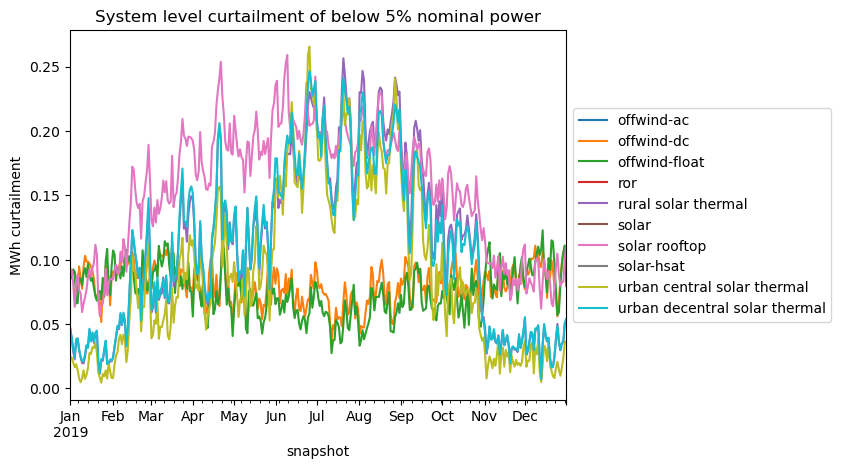

In [219]:
#how to get hours of curtailment?  #this is for 2020
network = Scenario2020[0]
renewable_carriers_generator = ['offwind-ac', 'offwind-dc', 'solar', 'offwind-float','solar-hsat', 'onwind', 'ror', 'urban central solar thermal', 'solar rooftop', 'rural solar thermal', 'urban decentral solar thermal']
renewable_generators_index = network.generators[network.generators.carrier.isin(renewable_carriers_generator)].index
renewable_generators_index
dispatch = network.generators_t.p[renewable_generators_index] #actual dispatch, generators are columns
network.generators_t.p_max_pu[renewable_generators_index] 
p_nom_max_series = network.generators_t.p_max_pu.multiply(network.generators.p_nom_opt).dropna(axis=1)
p_nom_max_series.columns.isin(renewable_generators_index) 
renewable_generators_index.isin(p_nom_max_series.columns) #great they all overlap 
network.generators_t.p[renewable_generators_index]
result = dispatch[p_nom_max_series.columns] #now result is the dispatch dataframe with the column reordered to match p_nom_max_series
result = p_nom_max_series - dispatch
#result = result.T.groupby(network.generators.carrier).sum() #so this is a time series of curtailment....
#now I need some sort of threshold, otherwise it will be as if every since hour! 
result = result * network.snapshot_weightings.objective[0] #now turning it into a MWh value 
result #I should probably sy, if it's not more than x, I'm discarding it, and the goal will to be to get the threshold allright 
#only consider it curtailment if it is above 100kWh? 
#maybe if the lost power is 10% or more of the generators nominal power it is considered 'curtailed?'
result
#officially I think the way to tackle curtailment would be on a cost basis, but the marginal cost here is not time varying
ten_percent_max_power = p_nom_max_series * .1
ten_percent_max_power = ten_percent_max_power[p_nom_max_series.columns]
ten_percent_max_energy = ten_percent_max_power.copy() * network.snapshot_weightings.objective[0]
relative_curtailment_acheived = result[result > ten_percent_max_power] #is the curtailment value is above ten percent the maximum power * snapshot time, keep as "curtailment"
relative_curtailment_acheived = relative_curtailment_acheived.T.groupby(network.generators.carrier).sum()
pd.DataFrame((relative_curtailment_acheived == 0).value_counts()) #all types of assets have curtailment at every snapshot  except ror? 
relative_curtailment_acheived.T.plot()
plt.ylabel('MWh curtailment')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
#would this be different if it was 10 percent below grouped power? 
grouped_ten_percent = ten_percent_max_energy.T.groupby(network.generators.carrier).sum().copy()
result_grouped = (result.copy().T.groupby(network.generators.carrier).sum())
relative_curtailment_acheived_grouped = result_grouped[result_grouped > grouped_ten_percent]
relative_curtailment_acheived_grouped.T.plot()
plt.ylabel('MWh curtailment')
plt.title('System level curtailment of below 10% nominal power')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

relative_curtailment_acheived_grouped.drop('onwind').T.plot()
plt.ylabel('MWh curtailment')
plt.title('System level curtailment without onwind, below 10% nominal power')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


#what these two things are considering are curtailment across the system vs curtailment of the individual assset
#would this be different if it was 5 percent below grouped power? 
ten_percent_max_power = p_nom_max_series * .05
ten_percent_max_energy = ten_percent_max_power.copy() * network.snapshot_weightings.objective[0]
grouped_ten_percent = ten_percent_max_energy.T.groupby(network.generators.carrier).sum().copy()
result_grouped = (result.copy().T.groupby(network.generators.carrier).sum())
ten_percent_max_power = ten_percent_max_power[p_nom_max_series.columns]
relative_curtailment_acheived_grouped = result_grouped[result_grouped > grouped_ten_percent]
relative_curtailment_acheived_grouped.T.plot()
plt.ylabel('MWh curtailment')
plt.title('System level curtailment of below 5% nominal power')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#would this be different if it was 5 percent below grouped power? 
ten_percent_max_power = p_nom_max_series * .05
ten_percent_max_energy = ten_percent_max_power.copy() * network.snapshot_weightings.objective[0]
grouped_ten_percent = ten_percent_max_energy.T.groupby(network.generators.carrier).sum().copy()
result_grouped = (result.copy().T.groupby(network.generators.carrier).sum())
ten_percent_max_power = ten_percent_max_power[p_nom_max_series.columns]
relative_curtailment_acheived_grouped = result_grouped[result_grouped > grouped_ten_percent]
relative_curtailment_acheived_grouped.drop('onwind').T.plot()
plt.ylabel('MWh curtailment')
plt.title('System level curtailment of below 5% nominal power')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#might be a better metric if it's fractional
#also, the metric won't just be in hours, it will be in carrier-hours (i.e. is this an any scenario?)
#multiply the amount of curtailment by the snapshot (assuming the curtailment here is averaged over the snapshot)


In [ ]:
network = Scenario2030[0]
EV_buses = network.stores[network.stores.carrier == 'EV battery'].bus
EV_charging_links = network.links[network.links.bus1.isin(EV_buses)].index
charging_dataframe = (network.links_t.p1[EV_charging_links] *-1)#.sum().sum()
any(charging_dataframe == 0) #oh it's going to be hard to get times of non charging in this scenario, because it's at 21

True

In [337]:
#And how were BEVs used in this case? #EV batteries only start at 2030 
index_names_2030 = ['Scenario2_2030', 'Scenario3_2_2030', 'Scenario3_3_2030', 'Scenario3_4_2030', 'Scenario3_5_2030','Scenario3_6_2030', 'Scenario3_7_2030', 'Scenario3_8_2030' , 'Scenario3_9_2030']
dataframe_2030_BEV = pd.DataFrame()
dataframe_2030_BEV.index = index_names_2030
dataframe_2030_BEV


#first setup of BEV descriptions 
dataframe_2030_BEV['Total capacity of EV batteries [Mwh]'] = np.zeros(len(index_names_2030))
for index_value, net in enumerate(Scenario2030):
    BEV_index_2030 = net.stores[net.stores.carrier == 'EV battery'].index
    EV_storage_capacity = net.stores.e_nom_opt.loc[BEV_index_2030].sum()
    dataframe_2030_BEV['Total capacity of EV batteries [Mwh]'][index_value] = EV_storage_capacity
    
#average state of charge 
dataframe_2030_BEV['Average SOC of the batteries [%]'] = np.zeros(len(index_names_2030))
for index_value, net in enumerate(Scenario2030):
    BEV_index_2030 = net.stores[net.stores.carrier == 'EV battery'].index
    EV_average_soc = net.stores_t.e[BEV_index_2030].mean().sum()
    dataframe_2030_BEV['Average SOC of the batteries [%]'][index_value] = EV_average_soc / EV_storage_capacity
    
dataframe_2030_BEV['Amount BEVs charged over the year [MWh]'] = np.zeros(len(index_names_2030))
for index_value, net in enumerate(Scenario2030):
    EV_buses = net.stores[net.stores.carrier == 'EV battery'].bus
    EV_charging_links = net.links[net.links.bus1.isin(EV_buses)].index
    Power_to_EV_batteries = (net.links_t.p1[EV_charging_links] *-1).sum().sum()
    dataframe_2030_BEV['Amount BEVs charged over the year [Mwh]'] = Power_to_EV_batteries * net.snapshot_weightings.objective[0]

dataframe_2030_BEV['Amount BEVs discharged over the year [MWh]'] = np.zeros(len(index_names_2030)) #V2G is set to true
for index_value, net in enumerate(Scenario2030):
    EV_buses = net.stores[net.stores.carrier == 'EV battery'].bus
    EV_charging_links = net.links[net.links.bus0.isin(EV_buses)].index
    Power_to_EV_batteries = (net.links_t.p1[EV_charging_links] *-1).sum().sum()
    dataframe_2030_BEV['Amount BEVs discharged over the year [MWh]'] = Power_to_EV_batteries * net.snapshot_weightings.objective[0]
#The question is, how do I know how much electric vehicles were particpating in demand side management? 
#amount of times battery hit minimum? 
#amount it discharged ot the grid DEFINITELY, but what about when it absorbed excess power? 
#how many hours did the charging to BEVs overlapp with the hrs of curtailment? 
dataframe_2030_BEV['Percentage of snapshots where charging overlapped with curtailmemt'] = np.zeros(len(index_names_2030))
dataframe_2030_BEV


,Total capacity of EV batteries [Mwh],Average SOC of the batteries [%],Amount BEVs charged over the year [MWh],Amount BEVs charged over the year [Mwh],Amount BEVs discharged over the year [MWh],Percentage of snapshots where charging overlapped with curtailmemt
Scenario2_2030,3.942057e+06,0.876105,0.0,2.926209e+08,212512.71245,0.0
Scenario3_2_2030,0.000000e+00,0.000000,0.0,2.926209e+08,212512.71245,0.0
Scenario3_3_2030,0.000000e+00,0.000000,0.0,2.926209e+08,212512.71245,0.0
Scenario3_4_2030,3.942057e+06,0.877551,0.0,2.926209e+08,212512.71245,0.0
Scenario3_5_2030,3.942057e+06,0.875700,0.0,2.926209e+08,212512.71245,0.0
Scenario3_6_2030,3.942057e+06,0.875920,0.0,2.926209e+08,212512.71245,0.0
Scenario3_7_2030,3.942057e+06,0.876189,0.0,2.926209e+08,212512.71245,0.0
Scenario3_8_2030,3.942057e+06,0.875688,0.0,2.926209e+08,212512.71245,0.0
Scenario3_9_2030,3.942057e+06,0.875660,0.0,2.926209e+08,212512.71245,0.0


In [ ]:
#Did use of hydrogen change? What was the percentrages for use of the hydrogen? 


2071762804.8970609

In [340]:
#What was the carbon output of each scenario?
scenario_choice = Scenario2050
for index_value, net in enumerate(scenario_choice):
    end_carbon_value = net.stores_t.e['co2 atmosphere'][-1]
    print(f"Carbon emission in tCO2 for scenio {index_names_2020[index_value]}:  {end_carbon_value:e}")

Carbon emission in tCO2 for scenio Scenario2_2020:  2.262264e+08
Carbon emission in tCO2 for scenio Scenario3_2_2020:  3.314820e+09
Carbon emission in tCO2 for scenio Scenario3_3_2020:  3.314820e+09
Carbon emission in tCO2 for scenio Scenario3_4_2020:  2.301959e+08
Carbon emission in tCO2 for scenio Scenario3_5_2020:  2.301959e+08
Carbon emission in tCO2 for scenio Scenario3_6_2020:  2.267582e+08
Carbon emission in tCO2 for scenio Scenario3_7_2020:  2.301959e+08
Carbon emission in tCO2 for scenio Scenario3_8_2020:  2.301959e+08
Carbon emission in tCO2 for scenio Scenario3_9_2020:  2.268397e+08


# Now I'm going to look at the scenarios with less BEV availability and compare them 

Katherie Shaw

July 25

In [346]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# This needs to be for all scenarios, will group by year 
Scenario2020_30pct_BEV_availability = [
    Scenario2_2020_30pct_BEV_availability,
    Scenario3_2_2020_30pct_BEV_availability,
    Scenario3_3_2020_30pct_BEV_availability,
    Scenario3_4_2020_30pct_BEV_availability,
    Scenario3_5_2020_30pct_BEV_availability,
    Scenario3_6_2020_30pct_BEV_availability,
    Scenario3_7_2020_30pct_BEV_availability,
    Scenario3_8_2020_30pct_BEV_availability,
    Scenario3_9_2020_30pct_BEV_availability
]

index_names_2020_30pct_BEV_availability = [
    'Scenario2_2020_30pct_BEV_availability',
    'Scenario3_2_2020_30pct_BEV_availability',
    'Scenario3_3_2020_30pct_BEV_availability',
    'Scenario3_4_2020_30pct_BEV_availability',
    'Scenario3_5_2020_30pct_BEV_availability',
    'Scenario3_6_2020_30pct_BEV_availability',
    'Scenario3_7_2020_30pct_BEV_availability',
    'Scenario3_8_2020_30pct_BEV_availability',
    'Scenario3_9_2020_30pct_BEV_availability'
]
generator_supply = 0
dataframe_2020_curtailment_30pct_BEV_availability = pd.DataFrame()
dataframe_2020_curtailment_30pct_BEV_availability.index = index_names_2020_30pct_BEV_availability

# initial setup of all the columns is 0.0 (to map structure)
dataframe_2020_curtailment_30pct_BEV_availability['total_energy_generated [Mwh]'] = np.zeros(len(index_names_2020_30pct_BEV_availability))
for index_value, net in enumerate(Scenario2020_30pct_BEV_availability):
    generator_supply = net.statistics()['Supply'].loc['Generator']
    generator_supply = generator_supply.drop('oil primary')
    generator_supply = generator_supply.sum().sum()
    dataframe_2020_curtailment_30pct_BEV_availability['total_energy_generated [Mwh]'][index_value] = generator_supply

# get only renewable values of supply
dataframe_2020_curtailment_30pct_BEV_availability['renewable_energy_generated [MWh]'] = np.zeros(len(index_names_2020_30pct_BEV_availability))
for index_value, net in enumerate(Scenario2020_30pct_BEV_availability):
    generator_supply = net.statistics()['Supply'].loc['Generator']
    generator_supply = generator_supply.drop('oil primary')
    generator_supply = generator_supply.loc[renewables_str]
    generator_supply = generator_supply.sum().sum()
    dataframe_2020_curtailment_30pct_BEV_availability['renewable_energy_generated [MWh]'][index_value] = generator_supply

# optimal capacity
dataframe_2020_curtailment_30pct_BEV_availability['Optimal Capacity of renewables [MW]'] = np.zeros(len(index_names_2020_30pct_BEV_availability))
for index_value, net in enumerate(Scenario2020_30pct_BEV_availability):
    generator_supply = net.statistics()['Optimal Capacity'].loc['Generator']
    generator_supply = generator_supply.drop('oil primary')
    generator_supply = generator_supply.loc[renewables_str]
    generator_supply = generator_supply.sum().sum()
    dataframe_2020_curtailment_30pct_BEV_availability['Optimal Capacity of renewables [MW]'][index_value] = generator_supply

# amount of energy curtailed 
dataframe_2020_curtailment_30pct_BEV_availability['amount of energy curtailed [MWh]'] = np.zeros(len(index_names_2020_30pct_BEV_availability))
for index_value, net in enumerate(Scenario2020_30pct_BEV_availability):
    avail = (
        net.generators_t.p_max_pu.multiply(net.generators.p_nom_opt)
        .sum()
        .groupby(net.generators.carrier)
        .sum()
    )
    used = net.generators_t.p.sum().groupby(net.generators.carrier).sum()
    curtailment_values = ((avail - used) * net.snapshot_weightings.objective[0])[(avail - used) * net.snapshot_weightings.objective[0] > 0]
    curtailment_values = curtailment_values.sum()
    dataframe_2020_curtailment_30pct_BEV_availability['amount of energy curtailed [MWh]'][index_value] = curtailment_values

# ratio of curtailed power to total power 
dataframe_2020_curtailment_30pct_BEV_availability['ratio of curtailed power to total power [-]'] = np.zeros(len(index_names_2020_30pct_BEV_availability))
dataframe_2020_curtailment_30pct_BEV_availability['ratio of curtailed power to total power [-]'] = (
    dataframe_2020_curtailment_30pct_BEV_availability['amount of energy curtailed [MWh]'] /
    dataframe_2020_curtailment_30pct_BEV_availability['renewable_energy_generated [MWh]']
)

# percentage of hours where curtailment took place (placeholder column for later use)
dataframe_2020_curtailment_30pct_BEV_availability['percentage of hours where curtailment took place'] = np.zeros(len(index_names_2020_30pct_BEV_availability))

dataframe_2020_curtailment_30pct_BEV_availability


,total_energy_generated [Mwh],renewable_energy_generated [MWh],Optimal Capacity of renewables [MW],amount of energy curtailed [MWh],ratio of curtailed power to total power [-],percentage of hours where curtailment took place
Scenario2_2020_30pct_BEV_availability,9.498615e+09,1.283467e+09,677605.58911,8.693405e+06,0.006773,0.0
Scenario3_2_2020_30pct_BEV_availability,9.497027e+09,1.280357e+09,676034.09209,8.705264e+06,0.006799,0.0
Scenario3_3_2020_30pct_BEV_availability,9.496980e+09,1.280419e+09,676066.61794,8.706118e+06,0.006799,0.0
Scenario3_4_2020_30pct_BEV_availability,9.498627e+09,1.283437e+09,677593.39880,8.700080e+06,0.006779,0.0
Scenario3_5_2020_30pct_BEV_availability,9.498540e+09,1.283199e+09,677471.68471,8.700467e+06,0.006780,0.0
Scenario3_6_2020_30pct_BEV_availability,9.498533e+09,1.283187e+09,677467.36371,8.700412e+06,0.006780,0.0
Scenario3_7_2020_30pct_BEV_availability,9.498531e+09,1.283182e+09,677464.45715,8.700234e+06,0.006780,0.0
Scenario3_8_2020_30pct_BEV_availability,9.498587e+09,1.283469e+09,677610.67990,8.700768e+06,0.006779,0.0
Scenario3_9_2020_30pct_BEV_availability,9.498622e+09,1.283424e+09,677586.71057,8.699974e+06,0.006779,0.0


In [342]:
# This needs to be for all scenarios, will group by year 
Scenario2030_30pct_BEV_availability = [
    Scenario2_2030_30pct_BEV_availability,
    Scenario3_2_2030_30pct_BEV_availability,
    Scenario3_3_2030_30pct_BEV_availability,
    Scenario3_4_2030_30pct_BEV_availability,
    Scenario3_5_2030_30pct_BEV_availability,
    Scenario3_6_2030_30pct_BEV_availability,
    Scenario3_7_2030_30pct_BEV_availability,
    Scenario3_8_2030_30pct_BEV_availability,
    Scenario3_9_2030_30pct_BEV_availability
]
index_names_2030_30pct_BEV_availability = [
    'Scenario2_2030_30pct_BEV_availability',
    'Scenario3_2_2030_30pct_BEV_availability',
    'Scenario3_3_2030_30pct_BEV_availability',
    'Scenario3_4_2030_30pct_BEV_availability',
    'Scenario3_5_2030_30pct_BEV_availability',
    'Scenario3_6_2030_30pct_BEV_availability',
    'Scenario3_7_2030_30pct_BEV_availability',
    'Scenario3_8_2030_30pct_BEV_availability',
    'Scenario3_9_2030_30pct_BEV_availability'

]
dataframe_2030_curtailment_30pct_BEV_availability = pd.DataFrame()
dataframe_2030_curtailment_30pct_BEV_availability.index = index_names_2030_30pct_BEV_availability

dataframe_2030_curtailment_30pct_BEV_availability['total_energy_generated [Mwh]'] = np.zeros(len(index_names_2030_30pct_BEV_availability))
for index_value, net in enumerate(Scenario2030_30pct_BEV_availability):
    generator_supply = net.statistics()['Supply'].loc['Generator']
    generator_supply = generator_supply.drop('oil primary')
    generator_supply = generator_supply.sum().sum()
    dataframe_2030_curtailment_30pct_BEV_availability['total_energy_generated [Mwh]'][index_value] = generator_supply

dataframe_2030_curtailment_30pct_BEV_availability['renewable_energy_generated [MWh]'] = np.zeros(len(index_names_2030_30pct_BEV_availability))
for index_value, net in enumerate(Scenario2030_30pct_BEV_availability):
    generator_supply = net.statistics()['Supply'].loc['Generator']
    generator_supply = generator_supply.drop('oil primary')
    generator_supply = generator_supply.loc[renewables_str]
    generator_supply = generator_supply.sum().sum()
    dataframe_2030_curtailment_30pct_BEV_availability['renewable_energy_generated [MWh]'][index_value] = generator_supply

dataframe_2030_curtailment_30pct_BEV_availability['Optimal Capacity of renewables [MW]'] = np.zeros(len(index_names_2030_30pct_BEV_availability))
for index_value, net in enumerate(Scenario2030_30pct_BEV_availability):
    generator_supply = net.statistics()['Optimal Capacity'].loc['Generator']
    generator_supply = generator_supply.drop('oil primary')
    generator_supply = generator_supply.loc[renewables_str]
    generator_supply = generator_supply.sum().sum()
    dataframe_2030_curtailment_30pct_BEV_availability['Optimal Capacity of renewables [MW]'][index_value] = generator_supply

dataframe_2030_curtailment_30pct_BEV_availability['amount of energy curtailed [MWh]'] = np.zeros(len(index_names_2030_30pct_BEV_availability))
for index_value, net in enumerate(Scenario2030_30pct_BEV_availability):
    avail = (
        net.generators_t.p_max_pu.multiply(network.generators.p_nom_opt)
        .sum()
        .groupby(network.generators.carrier)
        .sum()
    )
    used = net.generators_t.p.sum().groupby(net.generators.carrier).sum()
    curtailment_values = ((avail - used) * net.snapshot_weightings.objective[0])[(avail - used) * net.snapshot_weightings.objective[0] > 0]
    curtailment_values = curtailment_values.sum()
    dataframe_2030_curtailment_30pct_BEV_availability['amount of energy curtailed [MWh]'][index_value] = curtailment_values

dataframe_2030_curtailment_30pct_BEV_availability['ratio of curtailed power to total power [-]'] = np.zeros(len(index_names_2030_30pct_BEV_availability))
for index_value, net in enumerate(Scenario2030_30pct_BEV_availability):
    dataframe_2030_curtailment_30pct_BEV_availability['ratio of curtailed power to total power [-]'] = dataframe_2030_curtailment_30pct_BEV_availability['amount of energy curtailed [MWh]'] / dataframe_2030_curtailment_30pct_BEV_availability['renewable_energy_generated [MWh]']

dataframe_2030_curtailment_30pct_BEV_availability['percentage of hours where curtailment took place'] = np.zeros(len(index_names_2030_30pct_BEV_availability))
dataframe_2030_curtailment_30pct_BEV_availability


,total_energy_generated [Mwh],renewable_energy_generated [MWh],Optimal Capacity of renewables [MW],amount of energy curtailed [MWh],ratio of curtailed power to total power [-],percentage of hours where curtailment took place
Scenario2_2030_30pct_BEV_availability,8.128824e+09,2.790084e+09,1.531813e+06,1.782346e+07,0.006388,0.0
Scenario3_2_2030_30pct_BEV_availability,9.497027e+09,1.280357e+09,6.760341e+05,3.886947e+06,0.003036,0.0
Scenario3_3_2030_30pct_BEV_availability,9.496980e+09,1.280419e+09,6.760666e+05,3.370768e+06,0.002633,0.0
Scenario3_4_2030_30pct_BEV_availability,8.117464e+09,2.774758e+09,1.523050e+06,2.979850e+07,0.010739,0.0
Scenario3_5_2030_30pct_BEV_availability,8.128808e+09,2.790078e+09,1.531877e+06,1.788652e+07,0.006411,0.0
Scenario3_6_2030_30pct_BEV_availability,8.128816e+09,2.790083e+09,1.531846e+06,1.753221e+07,0.006284,0.0
Scenario3_7_2030_30pct_BEV_availability,8.094873e+09,2.743955e+09,1.504558e+06,6.092651e+07,0.022204,0.0
Scenario3_8_2030_30pct_BEV_availability,8.128790e+09,2.790062e+09,1.531838e+06,1.830855e+07,0.006562,0.0
Scenario3_9_2030_30pct_BEV_availability,8.128819e+09,2.790092e+09,1.531864e+06,1.832844e+07,0.006569,0.0


In [344]:
# This needs to be for all scenarios, will group by year 
Scenario2040_30pct_BEV_availability = [
    Scenario2_2040_30pct_BEV_availability,
    Scenario3_2_2040_30pct_BEV_availability,
    Scenario3_3_2040_30pct_BEV_availability,
    Scenario3_4_2040_30pct_BEV_availability,
    Scenario3_5_2040_30pct_BEV_availability,
    Scenario3_6_2040_30pct_BEV_availability,
    Scenario3_7_2040_30pct_BEV_availability,
    Scenario3_8_2040_30pct_BEV_availability,
    Scenario3_9_2040_30pct_BEV_availability
]
index_names_2040_30pct_BEV_availability = [
    'Scenario2_2040_30pct_BEV_availability',
    'Scenario3_2_2040_30pct_BEV_availability',
    'Scenario3_3_2040_30pct_BEV_availability',
    'Scenario3_4_2040_30pct_BEV_availability',
    'Scenario3_5_2040_30pct_BEV_availability',
    'Scenario3_6_2040_30pct_BEV_availability',
    'Scenario3_7_2040_30pct_BEV_availability',
    'Scenario3_8_2040_30pct_BEV_availability',
    'Scenario3_9_2040_30pct_BEV_availability'
]
dataframe_2040_curtailment_30pct_BEV_availability = pd.DataFrame()
dataframe_2040_curtailment_30pct_BEV_availability.index = index_names_2040_30pct_BEV_availability

# initial setup of all the columns is 0.0 (because it helped me map what I needed to view)
dataframe_2040_curtailment_30pct_BEV_availability['total_energy_generated [Mwh]'] = np.zeros(len(index_names_2040_30pct_BEV_availability))
for index_value, net in enumerate(Scenario2040_30pct_BEV_availability):
    generator_supply = net.statistics()['Supply'].loc['Generator']
    generator_supply = generator_supply.drop('oil primary')
    generator_supply = generator_supply.sum().sum()
    dataframe_2040_curtailment_30pct_BEV_availability['total_energy_generated [Mwh]'][index_value] = generator_supply

# get only renewable values of supply
dataframe_2040_curtailment_30pct_BEV_availability['renewable_energy_generated [MWh]'] = np.zeros(len(index_names_2040_30pct_BEV_availability))
for index_value, net in enumerate(Scenario2040_30pct_BEV_availability):
    generator_supply = net.statistics()['Supply'].loc['Generator']
    generator_supply = generator_supply.drop('oil primary')
    generator_supply = generator_supply.loc[renewables_str]
    generator_supply = generator_supply.sum().sum()
    dataframe_2040_curtailment_30pct_BEV_availability['renewable_energy_generated [MWh]'][index_value] = generator_supply

# optimal capacity
dataframe_2040_curtailment_30pct_BEV_availability['Optimal Capacity of renewables [MW]'] = np.zeros(len(index_names_2040_30pct_BEV_availability))
for index_value, net in enumerate(Scenario2040_30pct_BEV_availability):
    generator_supply = net.statistics()['Optimal Capacity'].loc['Generator']
    generator_supply = generator_supply.drop('oil primary')
    generator_supply = generator_supply.loc[renewables_str]
    generator_supply = generator_supply.sum().sum()
    dataframe_2040_curtailment_30pct_BEV_availability['Optimal Capacity of renewables [MW]'][index_value] = generator_supply

# amount of energy curtailed 
dataframe_2040_curtailment_30pct_BEV_availability['amount of energy curtailed [MWh]'] = np.zeros(len(index_names_2040_30pct_BEV_availability))
for index_value, net in enumerate(Scenario2040_30pct_BEV_availability):
    avail = (
        net.generators_t.p_max_pu.multiply(network.generators.p_nom_opt)
        .sum()
        .groupby(network.generators.carrier)
        .sum()
    )
    used = net.generators_t.p.sum().groupby(net.generators.carrier).sum()
    curtailment_values = ((avail - used) * net.snapshot_weightings.objective[0])[(avail - used) * net.snapshot_weightings.objective[0] > 0]
    curtailment_values = curtailment_values.sum()
    dataframe_2040_curtailment_30pct_BEV_availability['amount of energy curtailed [MWh]'][index_value] = curtailment_values

# ratio of curtailed power to total power 
dataframe_2040_curtailment_30pct_BEV_availability['ratio of curtailed power to total power [-]'] = np.zeros(len(index_names_2040_30pct_BEV_availability))
for index_value, net in enumerate(Scenario2040_30pct_BEV_availability):
    dataframe_2040_curtailment_30pct_BEV_availability['ratio of curtailed power to total power [-]'] = dataframe_2040_curtailment_30pct_BEV_availability['amount of energy curtailed [MWh]'] / dataframe_2040_curtailment_30pct_BEV_availability['renewable_energy_generated [MWh]']

# percentage of hours where curtailment took place 
dataframe_2040_curtailment_30pct_BEV_availability['percentage of hours where curtailment took place'] = np.zeros(len(index_names_2040_30pct_BEV_availability))
dataframe_2040_curtailment_30pct_BEV_availability

,total_energy_generated [Mwh],renewable_energy_generated [MWh],Optimal Capacity of renewables [MW],amount of energy curtailed [MWh],ratio of curtailed power to total power [-],percentage of hours where curtailment took place
Scenario2_2040_30pct_BEV_availability,1.063933e+10,8.676409e+09,4.481029e+06,2.193813e+08,0.025285,0.0
Scenario3_2_2040_30pct_BEV_availability,9.497027e+09,1.280357e+09,6.760341e+05,3.886947e+06,0.003036,0.0
Scenario3_3_2040_30pct_BEV_availability,9.496980e+09,1.280419e+09,6.760666e+05,3.370768e+06,0.002633,0.0
Scenario3_4_2040_30pct_BEV_availability,1.070351e+10,8.479951e+09,4.544992e+06,1.443092e+08,0.017018,0.0
Scenario3_5_2040_30pct_BEV_availability,1.070309e+10,8.480688e+09,4.544123e+06,1.306798e+08,0.015409,0.0
Scenario3_6_2040_30pct_BEV_availability,1.063925e+10,8.676299e+09,4.481071e+06,2.197561e+08,0.025328,0.0
Scenario3_7_2040_30pct_BEV_availability,1.089395e+10,8.408388e+09,4.653687e+06,1.195969e+08,0.014224,0.0
Scenario3_8_2040_30pct_BEV_availability,1.089613e+10,8.410751e+09,4.649049e+06,7.384190e+07,0.008779,0.0
Scenario3_9_2040_30pct_BEV_availability,1.063885e+10,8.675915e+09,4.481103e+06,2.176634e+08,0.025088,0.0


In [347]:
# This needs to be for all scenarios, will group by year 
Scenario2050_30pct_BEV_availability = [
    Scenario2_2050_30pct_BEV_availability,
    Scenario3_2_2050_30pct_BEV_availability,
    Scenario3_3_2050_30pct_BEV_availability,
    Scenario3_4_2050_30pct_BEV_availability,
    Scenario3_5_2050_30pct_BEV_availability,
    Scenario3_6_2050_30pct_BEV_availability,
    Scenario3_7_2050_30pct_BEV_availability,
    Scenario3_8_2050_30pct_BEV_availability,
    Scenario3_9_2050_30pct_BEV_availability
]
index_names_2050_30pct_BEV_availability = [
    'Scenario2_2050_30pct_BEV_availability',
    'Scenario3_2_2050_30pct_BEV_availability',
    'Scenario3_3_2050_30pct_BEV_availability',
    'Scenario3_4_2050_30pct_BEV_availability',
    'Scenario3_5_2050_30pct_BEV_availability',
    'Scenario3_6_2050_30pct_BEV_availability',
    'Scenario3_7_2050_30pct_BEV_availability',
    'Scenario3_8_2050_30pct_BEV_availability',
    'Scenario3_9_2050_30pct_BEV_availability'


]
dataframe_2050_curtailment_30pct_BEV_availability = pd.DataFrame()
dataframe_2050_curtailment_30pct_BEV_availability.index = index_names_2050_30pct_BEV_availability

# initial setup of all the columns is 0.0 (because it helped me map what I needed to view)
dataframe_2050_curtailment_30pct_BEV_availability['total_energy_generated [Mwh]'] = np.zeros(len(index_names_2050_30pct_BEV_availability))
for index_value, net in enumerate(Scenario2050_30pct_BEV_availability):
    generator_supply = net.statistics()['Supply'].loc['Generator']
    generator_supply = generator_supply.drop('oil primary')
    generator_supply = generator_supply.sum().sum()
    dataframe_2050_curtailment_30pct_BEV_availability['total_energy_generated [Mwh]'][index_value] = generator_supply

# get only renewable values of supply
dataframe_2050_curtailment_30pct_BEV_availability['renewable_energy_generated [MWh]'] = np.zeros(len(index_names_2050_30pct_BEV_availability))
for index_value, net in enumerate(Scenario2050_30pct_BEV_availability):
    generator_supply = net.statistics()['Supply'].loc['Generator']
    generator_supply = generator_supply.drop('oil primary')
    generator_supply = generator_supply.loc[renewables_str]
    generator_supply = generator_supply.sum().sum()
    dataframe_2050_curtailment_30pct_BEV_availability['renewable_energy_generated [MWh]'][index_value] = generator_supply

# optimal capacity
dataframe_2050_curtailment_30pct_BEV_availability['Optimal Capacity of renewables [MW]'] = np.zeros(len(index_names_2050_30pct_BEV_availability))
for index_value, net in enumerate(Scenario2050_30pct_BEV_availability):
    generator_supply = net.statistics()['Optimal Capacity'].loc['Generator']
    generator_supply = generator_supply.drop('oil primary')
    generator_supply = generator_supply.loc[renewables_str]
    generator_supply = generator_supply.sum().sum()
    dataframe_2050_curtailment_30pct_BEV_availability['Optimal Capacity of renewables [MW]'][index_value] = generator_supply

# amount of energy curtailed 
dataframe_2050_curtailment_30pct_BEV_availability['amount of energy curtailed [MWh]'] = np.zeros(len(index_names_2050_30pct_BEV_availability))
for index_value, net in enumerate(Scenario2050_30pct_BEV_availability):
    avail = (
        net.generators_t.p_max_pu.multiply(network.generators.p_nom_opt)
        .sum()
        .groupby(network.generators.carrier)
        .sum()
    )
    used = net.generators_t.p.sum().groupby(net.generators.carrier).sum()
    curtailment_values = ((avail - used) * net.snapshot_weightings.objective[0])[(avail - used) * net.snapshot_weightings.objective[0] > 0]
    curtailment_values = curtailment_values.sum()
    dataframe_2050_curtailment_30pct_BEV_availability['amount of energy curtailed [MWh]'][index_value] = curtailment_values

# ratio of curtailed power to total power 
dataframe_2050_curtailment_30pct_BEV_availability['ratio of curtailed power to total power [-]'] = np.zeros(len(index_names_2050_30pct_BEV_availability))
for index_value, net in enumerate(Scenario2050_30pct_BEV_availability):
    dataframe_2050_curtailment_30pct_BEV_availability['ratio of curtailed power to total power [-]'] = dataframe_2050_curtailment_30pct_BEV_availability['amount of energy curtailed [MWh]'] / dataframe_2050_curtailment_30pct_BEV_availability['renewable_energy_generated [MWh]']

# percentage of hours where curtailment took place 
dataframe_2050_curtailment_30pct_BEV_availability['percentage of hours where curtailment took place'] = np.zeros(len(index_names_2050_30pct_BEV_availability))
dataframe_2050_curtailment_30pct_BEV_availability


,total_energy_generated [Mwh],renewable_energy_generated [MWh],Optimal Capacity of renewables [MW],amount of energy curtailed [MWh],ratio of curtailed power to total power [-],percentage of hours where curtailment took place
Scenario2_2050_30pct_BEV_availability,1.015103e+10,8.578455e+09,4.233229e+06,1.426143e+08,0.016625,0.0
Scenario3_2_2050_30pct_BEV_availability,9.497027e+09,1.280357e+09,6.760341e+05,3.886947e+06,0.003036,0.0
Scenario3_3_2050_30pct_BEV_availability,9.496980e+09,1.280419e+09,6.760666e+05,3.370768e+06,0.002633,0.0
Scenario3_4_2050_30pct_BEV_availability,1.012476e+10,8.249171e+09,4.297193e+06,8.965909e+07,0.010869,0.0
Scenario3_5_2050_30pct_BEV_availability,1.012558e+10,8.249997e+09,4.296323e+06,7.427456e+07,0.009003,0.0
Scenario3_6_2050_30pct_BEV_availability,1.015086e+10,8.578433e+09,4.233270e+06,1.425198e+08,0.016614,0.0
Scenario3_7_2050_30pct_BEV_availability,1.012668e+10,8.035962e+09,4.406885e+06,8.339933e+07,0.010378,0.0
Scenario3_8_2050_30pct_BEV_availability,1.012388e+10,8.039654e+09,4.402248e+06,3.363975e+07,0.004184,0.0
Scenario3_9_2050_30pct_BEV_availability,1.014957e+10,8.578331e+09,4.233302e+06,1.406753e+08,0.016399,0.0


In [ ]:
#Comparing Ratios of Curtailment 

comparison_dataframe1 = pd.DataFrame()
comparison_dataframe1.index = ['2','3_2', '3_3', '3_4', '3_5', '3_6', '3_7', '3_8']
comparison_dataframe1['BEV_dsm = 0.9'] = dataframe_2020_curtailment['ratio of curtailed power to total power [-]']

# Fill new column by finding matching substring in the source index


#comparison_dataframe1['BEV_dsm = 0.3'] = dataframe_2020_curtailment_30pct_BEV_availability['ratio of curtailed power to total power [-]']
#comparison_dataframe1['curtailment higher'] = comparison_dataframe1.idxmax(axis=1)
comparison_dataframe1

,BEV_dsm = 0.9
2,NaN
3_3,NaN
3_3,NaN
3_4,NaN
3_5,NaN
3_6,NaN
3_7,NaN
3_8,NaN


In [356]:
import numpy as np
#2020 
# Ensure both indexes are strings
comparison_dataframe1 = pd.DataFrame()
comparison_dataframe1.index = ['2','3_2', '3_3', '3_4', '3_5', '3_6', '3_7', '3_8', '3_9']
dataframe_2020_curtailment.index = dataframe_2020_curtailment.index.astype(str)
comparison_dataframe1.index = comparison_dataframe1.index.astype(str)

# Column you want to transfer
column_to_transfer = 'ratio of curtailed power to total power [-]'

# Create the new column by matching substrings from the source - BEV = 0.9
comparison_dataframe1['BEV_dsm = 0.9'] = [
    dataframe_2020_curtailment.loc[
        dataframe_2020_curtailment.index[dataframe_2020_curtailment.index.str.contains(short_name)]
    ][column_to_transfer].values[0] if dataframe_2020_curtailment.index.str.contains(short_name).any() else np.nan
    for short_name in comparison_dataframe1.index
]
# Create the new column by matching substrings from the source - BEV = 0.9
comparison_dataframe1['BEV_dsm = 0.3'] = [
    dataframe_2020_curtailment_30pct_BEV_availability.loc[
        dataframe_2020_curtailment_30pct_BEV_availability.index[dataframe_2020_curtailment_30pct_BEV_availability.index.str.contains(short_name)]
    ][column_to_transfer].values[0] if dataframe_2020_curtailment_30pct_BEV_availability.index.str.contains(short_name).any() else np.nan
    for short_name in comparison_dataframe1.index
]

comparison_dataframe1['highest_curtailment'] = comparison_dataframe1.idxmax(axis=1)
comparison_dataframe1['curatilment_difference [Mwh]'] = dataframe_2020_curtailment['amount of energy curtailed [MWh]'] - dataframe_2020_curtailment_30pct_BEV_availability['amount of energy curtailed [MWh]']
comparison_dataframe1

,BEV_dsm = 0.9,BEV_dsm = 0.3,highest_curtailment,curatilment_difference [Mwh]
2,0.000088,0.006773,BEV_dsm = 0.3,NaN
3_2,0.002905,0.006799,BEV_dsm = 0.3,NaN
3_3,0.003040,0.006799,BEV_dsm = 0.3,NaN
3_4,0.000430,0.006779,BEV_dsm = 0.3,NaN
3_5,0.002534,0.006780,BEV_dsm = 0.3,NaN
3_6,0.000368,0.006780,BEV_dsm = 0.3,NaN
3_7,0.000104,0.006780,BEV_dsm = 0.3,NaN
3_8,0.000821,0.006779,BEV_dsm = 0.3,NaN
3_9,0.000284,0.006779,BEV_dsm = 0.3,NaN


In [357]:
#2030
# Ensure both indexes are strings
comparison_dataframe1 = pd.DataFrame()
comparison_dataframe1.index = ['2','3_2', '3_3', '3_4', '3_5', '3_6', '3_7', '3_8', '3_9']
dataframe_2030_curtailment.index = dataframe_2030_curtailment.index.astype(str)
comparison_dataframe1.index = comparison_dataframe1.index.astype(str)

# Column you want to transfer
column_to_transfer = 'ratio of curtailed power to total power [-]'

# Create the new column by matching substrings from the source - BEV = 0.9
comparison_dataframe1['BEV_dsm = 0.9'] = [
    dataframe_2030_curtailment.loc[
        dataframe_2030_curtailment.index[dataframe_2030_curtailment.index.str.contains(short_name)]
    ][column_to_transfer].values[0] if dataframe_2030_curtailment.index.str.contains(short_name).any() else np.nan
    for short_name in comparison_dataframe1.index
]

# Create the new column by matching substrings from the source - BEV = 0.3
comparison_dataframe1['BEV_dsm = 0.3'] = [
    dataframe_2030_curtailment_30pct_BEV_availability.loc[
        dataframe_2030_curtailment_30pct_BEV_availability.index[dataframe_2030_curtailment_30pct_BEV_availability.index.str.contains(short_name)]
    ][column_to_transfer].values[0] if dataframe_2030_curtailment_30pct_BEV_availability.index.str.contains(short_name).any() else np.nan
    for short_name in comparison_dataframe1.index
]

comparison_dataframe1['highest_curtailment'] = comparison_dataframe1.idxmax(axis=1)
comparison_dataframe1

,BEV_dsm = 0.9,BEV_dsm = 0.3,highest_curtailment
2,0.003651,0.006388,BEV_dsm = 0.3
3_2,0.002905,0.003036,BEV_dsm = 0.3
3_3,0.003040,0.002633,BEV_dsm = 0.9
3_4,0.007268,0.010739,BEV_dsm = 0.3
3_5,0.003794,0.006411,BEV_dsm = 0.3
3_6,0.003736,0.006284,BEV_dsm = 0.3
3_7,0.021584,0.022204,BEV_dsm = 0.3
3_8,0.003647,0.006562,BEV_dsm = 0.3
3_9,0.003655,0.006569,BEV_dsm = 0.3


In [360]:
#2040
# Ensure both indexes are strings
comparison_dataframe1 = pd.DataFrame()
comparison_dataframe1.index = ['2','3_2', '3_3', '3_4', '3_5', '3_6', '3_7', '3_8', '3_9']
dataframe_2040_curtailment.index = dataframe_2040_curtailment.index.astype(str)
comparison_dataframe1.index = comparison_dataframe1.index.astype(str)

# Column you want to transfer
column_to_transfer = 'ratio of curtailed power to total power [-]'

# Create the new column by matching substrings from the source - BEV = 0.9
comparison_dataframe1['BEV_dsm = 0.9'] = [
    dataframe_2040_curtailment.loc[
        dataframe_2040_curtailment.index[dataframe_2040_curtailment.index.str.contains(short_name)]
    ][column_to_transfer].values[0] if dataframe_2040_curtailment.index.str.contains(short_name).any() else np.nan
    for short_name in comparison_dataframe1.index
]

# Create the new column by matching substrings from the source - BEV = 0.3
comparison_dataframe1['BEV_dsm = 0.3'] = [
    dataframe_2040_curtailment_30pct_BEV_availability.loc[
        dataframe_2040_curtailment_30pct_BEV_availability.index[dataframe_2040_curtailment_30pct_BEV_availability.index.str.contains(short_name)]
    ][column_to_transfer].values[0] if dataframe_2040_curtailment_30pct_BEV_availability.index.str.contains(short_name).any() else np.nan
    for short_name in comparison_dataframe1.index
]

comparison_dataframe1['highest_curtailment'] = comparison_dataframe1.idxmax(axis=1)
comparison_dataframe1

,BEV_dsm = 0.9,BEV_dsm = 0.3,highest_curtailment
2,0.026577,0.025285,BEV_dsm = 0.9
3_2,0.002905,0.003036,BEV_dsm = 0.3
3_3,0.003040,0.002633,BEV_dsm = 0.9
3_4,0.009931,0.017018,BEV_dsm = 0.3
3_5,0.015985,0.015409,BEV_dsm = 0.9
3_6,0.025439,0.025328,BEV_dsm = 0.9
3_7,0.013804,0.014224,BEV_dsm = 0.3
3_8,0.008801,0.008779,BEV_dsm = 0.9
3_9,0.025425,0.025088,BEV_dsm = 0.9


In [359]:
#2050
# Ensure both indexes are strings
comparison_dataframe1 = pd.DataFrame()
comparison_dataframe1.index = ['2','3_2', '3_3', '3_4', '3_5', '3_6', '3_7', '3_8', '3_9']
dataframe_2050_curtailment.index = dataframe_2050_curtailment.index.astype(str)
comparison_dataframe1.index = comparison_dataframe1.index.astype(str)

# Column you want to transfer
column_to_transfer = 'ratio of curtailed power to total power [-]'

# Create the new column by matching substrings from the source - BEV = 0.9
comparison_dataframe1['BEV_dsm = 0.9'] = [
    dataframe_2050_curtailment.loc[
        dataframe_2050_curtailment.index[dataframe_2050_curtailment.index.str.contains(short_name)]
    ][column_to_transfer].values[0] if dataframe_2050_curtailment.index.str.contains(short_name).any() else np.nan
    for short_name in comparison_dataframe1.index
]

# Create the new column by matching substrings from the source - BEV = 0.3
comparison_dataframe1['BEV_dsm = 0.3'] = [
    dataframe_2050_curtailment_30pct_BEV_availability.loc[
        dataframe_2050_curtailment_30pct_BEV_availability.index[dataframe_2050_curtailment_30pct_BEV_availability.index.str.contains(short_name)]
    ][column_to_transfer].values[0] if dataframe_2050_curtailment_30pct_BEV_availability.index.str.contains(short_name).any() else np.nan
    for short_name in comparison_dataframe1.index
]

comparison_dataframe1['highest_curtailment'] = comparison_dataframe1.idxmax(axis=1)
comparison_dataframe1

,BEV_dsm = 0.9,BEV_dsm = 0.3,highest_curtailment
2,0.016884,0.016625,BEV_dsm = 0.9
3_2,0.002905,0.003036,BEV_dsm = 0.3
3_3,0.003040,0.002633,BEV_dsm = 0.9
3_4,0.006554,0.010869,BEV_dsm = 0.3
3_5,0.008637,0.009003,BEV_dsm = 0.3
3_6,0.015893,0.016614,BEV_dsm = 0.3
3_7,0.010149,0.010378,BEV_dsm = 0.3
3_8,0.004764,0.004184,BEV_dsm = 0.9
3_9,0.015677,0.016399,BEV_dsm = 0.3


conventional  geothermal    8.573949e+05
              nuclear       5.031243e+08
              CCGT          2.797235e+06
              OCGT          4.201314e+00
              coal          2.363428e+00
              lignite       2.294130e+00
dtype: float64
renewable  offwind-ac       7.292894e+08
           offwind-dc       9.027895e+08
           offwind-float    1.591501e+02
           onwind           2.237913e+09
           ror              1.542614e+08
           solar            3.006355e+09
           solar rooftop    1.153769e+09
           solar-hsat       2.980092e+08
dtype: float64
conventional  geothermal    8.573544e+05
              nuclear       5.049506e+08
              CCGT          2.651365e+06
              OCGT          2.958228e+00
              coal          1.429607e+00
              lignite       1.500348e+00
dtype: float64
renewable  offwind-ac       5.724548e+08
           offwind-dc       9.108677e+08
           offwind-float    1.035610e+02
           o

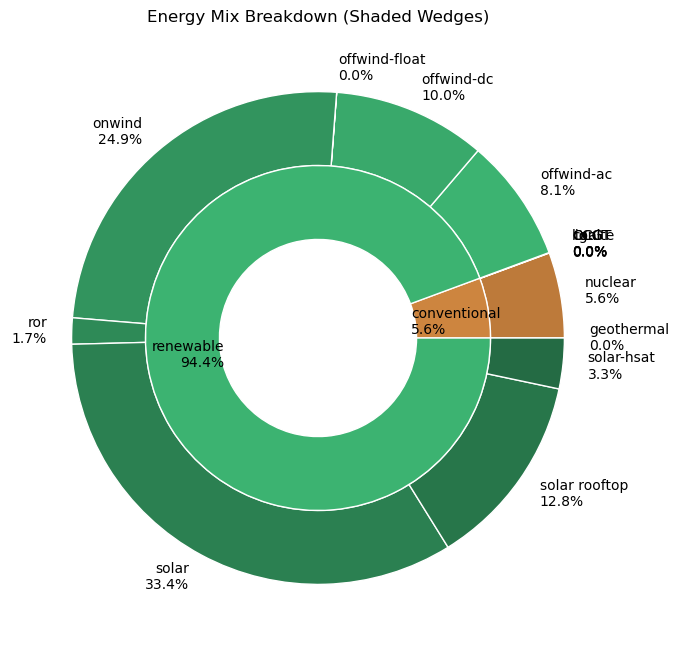

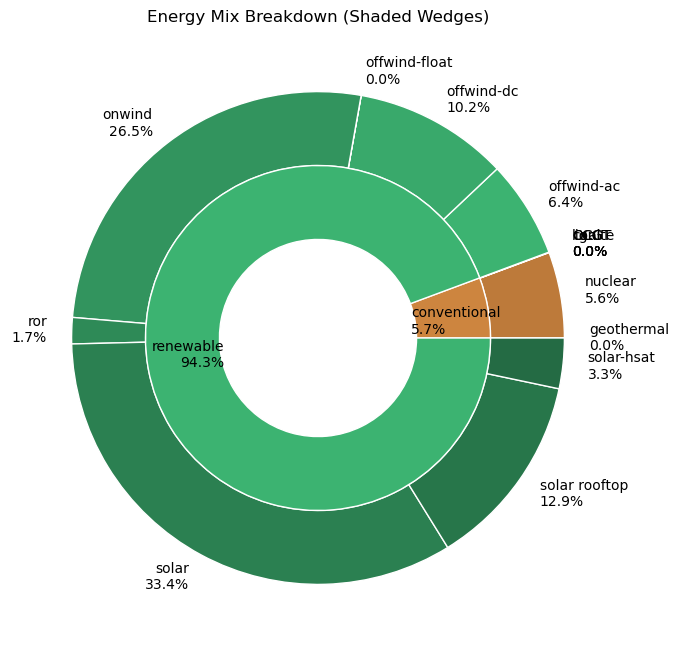

In [362]:
af.carrier_pie_chart(Scenario3_5_2040_30pct_BEV_availability)
af.carrier_pie_chart(Scenario3_5_2040)


In [301]:
string_mask = comparison_dataframe1.applymap(lambda x: isinstance(x, str))
string_mask

,BEV_dsm = 0.9,BEV_dsm = 0.3,highest_curatilment
2,False,False,True
3_3,False,False,True
3_3,False,False,True
3_4,False,False,True
3_5,False,False,True
3_6,False,False,True
3_7,False,False,True
3_8,False,False,True
